# Convolutional Neural Networks (CNNs)

## Quelle der Daten

https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?resource=download (zuletzt aufgerufen 01/2024)
    
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images.

## Installation der Bibliotheken

In [1]:
# Bibliotheken importieren, die für das Laden, Vorverarbeiten und Modellieren der Daten benötigt werden.
import os

import cv2

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import requests

import tempfile

import shutil

## Download der Daten

In [2]:
# URL des Datensatzes festlegen und temporäres Verzeichnis für den Download erstellen.
# load dataset from online resource, given here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
ds_url = "https://drive.usercontent.google.com/download?id=1bum9Sehb3AzUMHLhBMuowPKyr_PCrB3a&export=download&confirm=1"
temp_dir = tempfile.mkdtemp()
print(f"Temporary file-directory for saving dataset: '{temp_dir}'\n")

Temporary file-directory for saving dataset: '/tmp/tmp4tzwfjs6'



In [3]:
# for downloading from google-drive, use method described
# elsewhere (https://stackoverflow.com/a/39225272)
# with some modifications

def download_file_from_google_drive(URL, destination_dir):
    # Funktion zum Herunterladen einer Datei von Google Drive
    session = requests.Session()

    response = session.get(URL, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {"confirm": token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination_dir)


def get_confirm_token(response):
    # Funktion zum Abrufen des Bestätigungstokens für den Download
    for key, value in response.cookies.items():
        if key.startswith("download_warning"):
            return value

    return None


def save_response_content(response, destination_dir):
    # Funktion zum Speichern des Dateiinhaltes
    CHUNK_SIZE = 32768

    with open(destination_dir + "/data.zip", "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

# Die Datei von Google Drive herunterladen
download_file_from_google_drive(ds_url, temp_dir)

print("Folder structure inside 'tempdir':\n")
print(os.listdir(temp_dir))

Folder structure inside 'tempdir':

['data.zip']


In [4]:
# Entpacken der heruntergeladenen Zip-Datei
shutil.unpack_archive(filename=temp_dir + "/data.zip", extract_dir=temp_dir)
print("Folder structure inside 'tempdir':\n")
print(os.listdir(temp_dir))

Folder structure inside 'tempdir':

['data.zip', 'COVID-19_Radiography_Dataset']


## Einlesen und Präprozessierung der Daten

In [5]:
# Pfade zu den Bilderverzeichnissen festlegen und Anzahl der Bilder ausgeben
main_path = temp_dir + "/COVID-19_Radiography_Dataset"
print(os.listdir(main_path))

covid_dir = os.path.join(main_path, "COVID/images")
normal_dir = os.path.join(main_path, "Normal/images")

print("Anzahl Bilder mit COVID:", len(os.listdir(covid_dir)))
print("Anzahl normaler Bilder:", len(os.listdir(normal_dir)))

['COVID.metadata.xlsx', 'Viral Pneumonia', 'Lung_Opacity.metadata.xlsx', 'Lung_Opacity', 'README.md.txt', 'Viral Pneumonia.metadata.xlsx', 'COVID', 'Normal', 'Normal.metadata.xlsx']
Anzahl Bilder mit COVID: 3616
Anzahl normaler Bilder: 10192


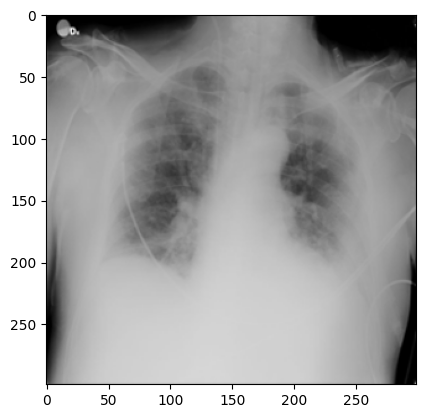

In [6]:
# Beispielbild laden und anzeigen
example_image = cv2.imread(os.path.join(covid_dir, "COVID-1.png"))

plt.imshow(example_image)


In [7]:
# Form des Beispielbildes ausgeben
print(example_image.shape)

(299, 299, 3)


In [8]:
# Funktion zum Laden und Vorverarbeiten von Bildern aus einem Verzeichnis
def loadImages(dir, size, label):
  images = []
  labels = []

  for i in range(len(size)):
    img_path = dir + "/" + size[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    img = cv2.resize(img, (100, 100))
    images.append(img)
    labels.append(label)

  images = np.asarray(images)

  return images, labels

In [9]:
# Laden und Beschriften von COVID-Bildern (10% des Datensatzes)
# (kann bei Bedarf / je nach Verfügbarkeit der Ressourcen angepasst werden)
covid_images, covid_labels = loadImages(covid_dir, os.listdir(covid_dir)[:int(0.1*len(os.listdir(covid_dir)))], 1)
print("Covid cases:\n")
print(len(covid_images), len(covid_labels))

Covid cases:

361 361


In [22]:
# Ausgabe der ersten 10 Covid-Labels
print(covid_labels[0:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
# Laden und Beschriften von normalen Bildern (10% des Datensatzes)
# (kann bei Bedarf / je nach Verfügbarkeit der Ressourcen angepasst werden)
normal_images, normal_labels = loadImages(normal_dir, os.listdir(normal_dir)[:int(0.1*len(os.listdir(normal_dir)))], 0)
print("Normal cases:\n")
print(len(normal_images), len(normal_labels))

Normal cases:

1019 1019


In [21]:
# Ausgabe der ersten 10 Labels von normalen Fällen
print(normal_labels[0:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Aufteilung der Daten

In [11]:
# Kombinieren der COVID- und normalen Bilddaten und Labels
x = np.r_[covid_images, normal_images]

y = np.r_[covid_labels, normal_labels]

In [12]:
# Aufteilen der Daten in Trainings- und Testsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

## CNN-Architektur

In [13]:
# Form des ersten Testbildes ausgeben
print(x_test[0].shape)

(100, 100, 3)


In [14]:
# Erstellen und Zusammenfassen der CNN-Modellarchitektur
model = Sequential()

model.add(Conv2D(32, 3, input_shape = (100, 100, 3), activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, 3, activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, 3, activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 959,137 (3.66 MB)

 Trainable params: 959,137 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

## Modelltraining und -evaluation

In [15]:
# Kompilieren des Modells mit Optimizer, Verlustfunktion und Metriken
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [16]:
# Trainieren des Modells (für 5 Epochen; kann bei Bedarf /
# je nach Verfügbarkeit von Ressourcen angepasst werden)
model.fit(x_train, y_train,
          batch_size = 32, epochs = 5,
          validation_data = (x_test, y_test))

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.7385 - loss: 0.5968 - val_accuracy: 0.7343 - val_loss: 0.5308
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.7595 - loss: 0.4744 - val_accuracy: 0.8261 - val_loss: 0.4166
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - accuracy: 0.7992 - loss: 0.4058 - val_accuracy: 0.8116 - val_loss: 0.4117
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.8605 - loss: 0.3108 - val_accuracy: 0.8454 - val_loss: 0.3761
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.8659 - loss: 0.3264 - val_accuracy: 0.8309 - val_loss: 0.3773


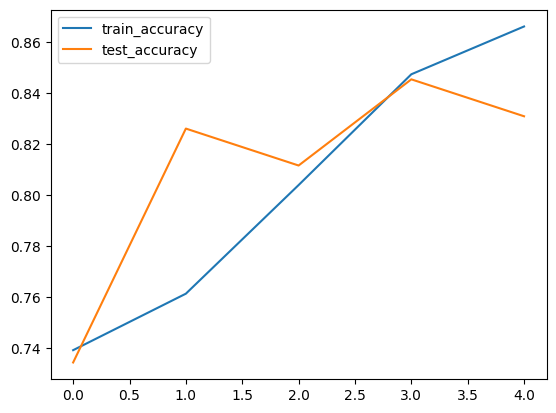

In [17]:
# Plotten der Trainings- und Testgenauigkeit
plt.plot(model.history.history["accuracy"], label = "train_accuracy")
plt.plot(model.history.history["val_accuracy"], label = "test_accuracy")
plt.legend()
plt.show()

In [18]:
# Vorhersagen mit dem Modell treffen und in binäre Klassen umwandeln
y_pred = model.predict(x_test)

y_pred_bin = (y_pred > 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


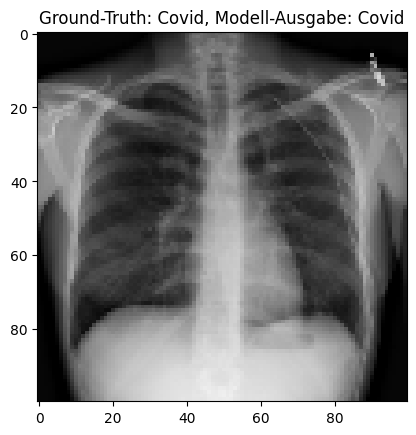

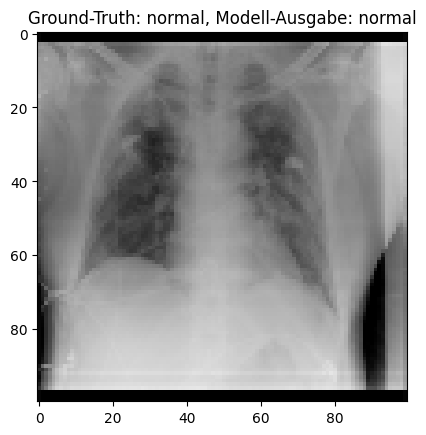

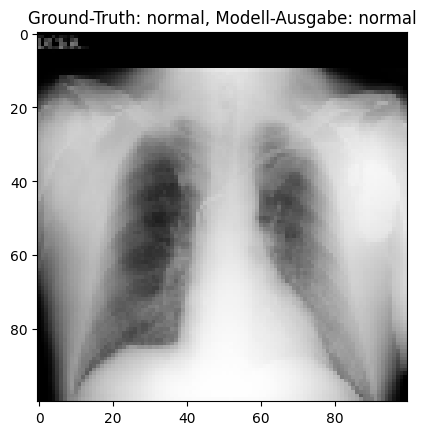

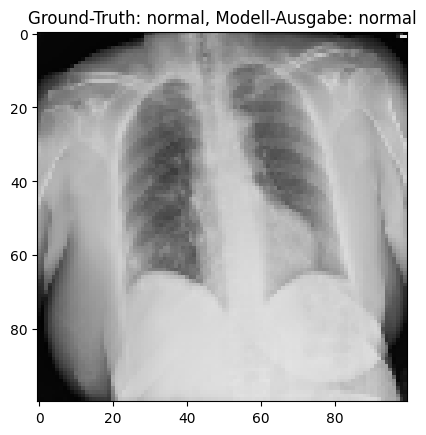

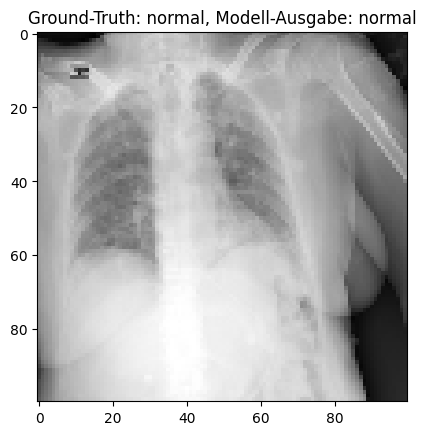

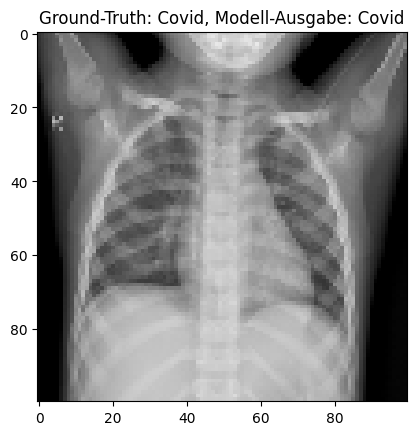

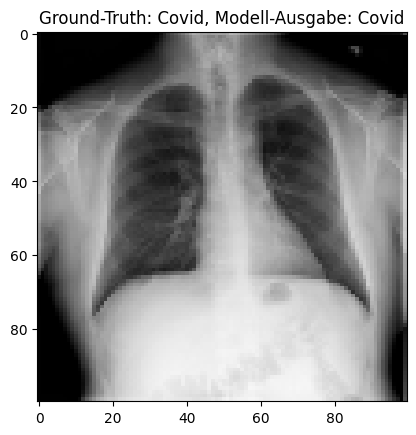

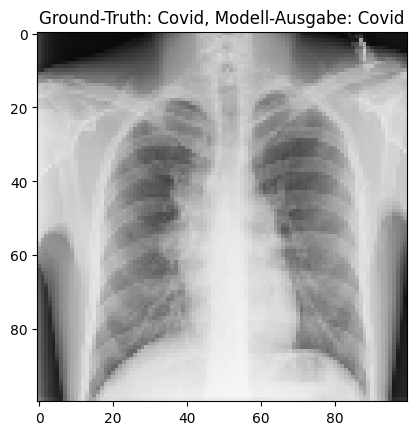

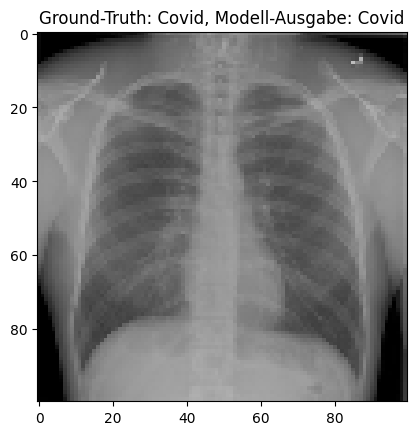

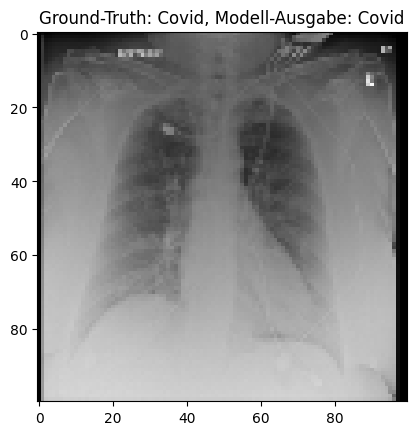

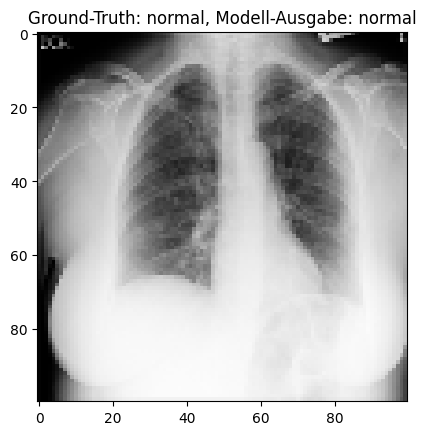

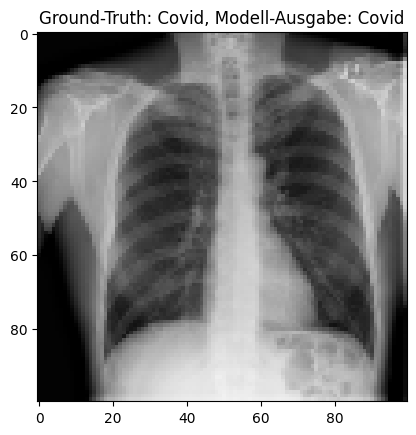

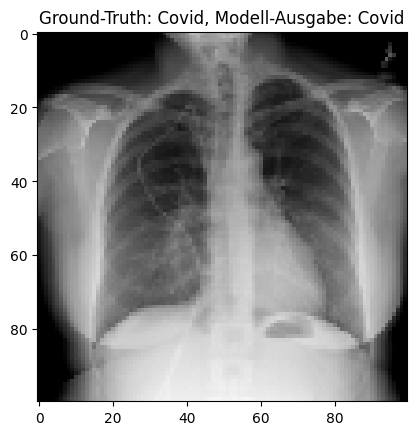

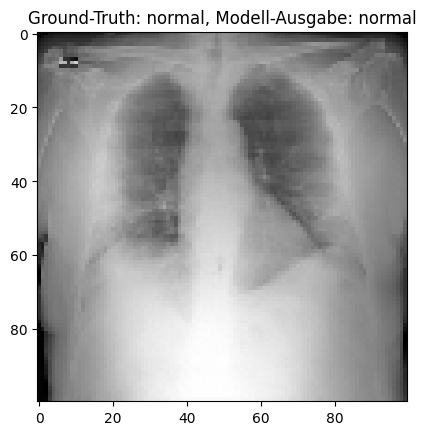

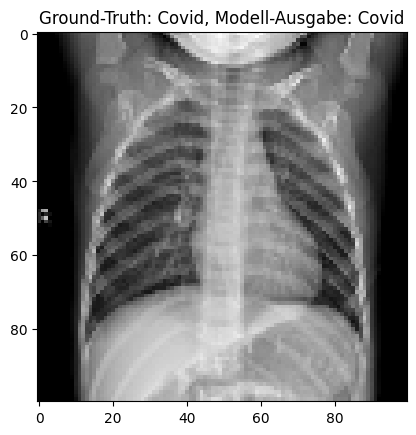

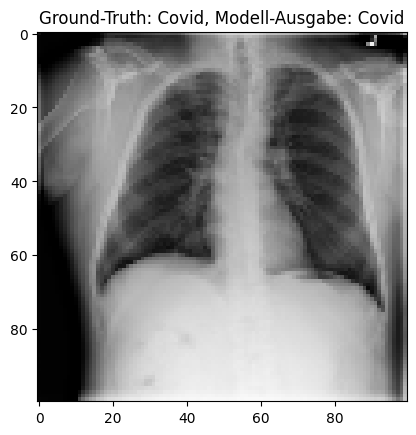

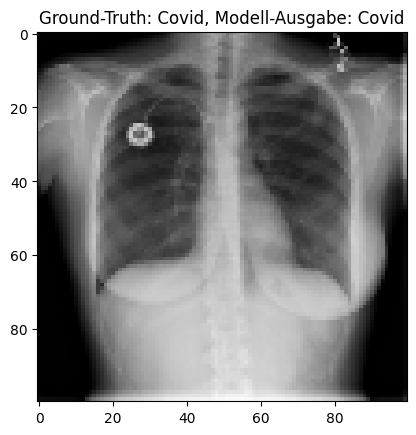

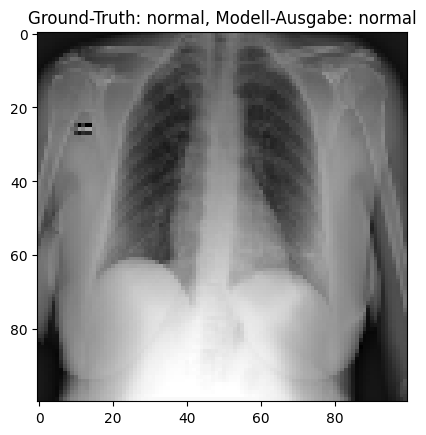

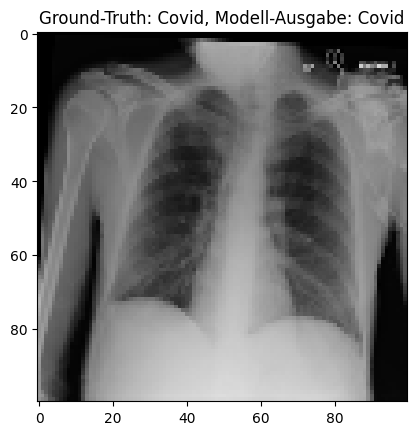

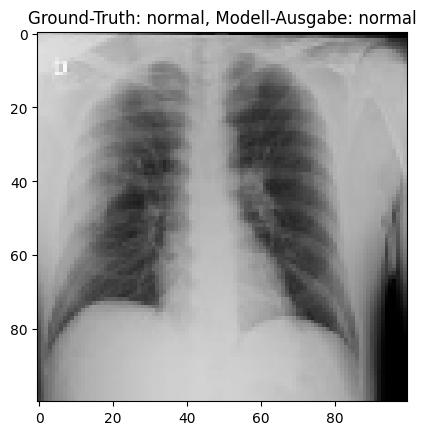

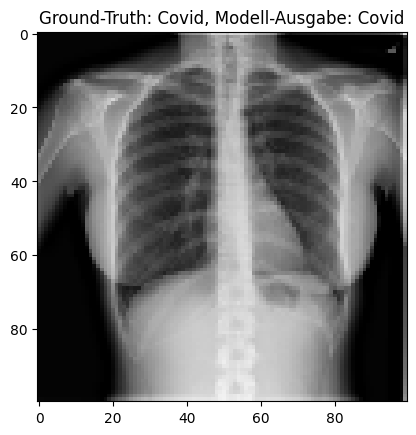

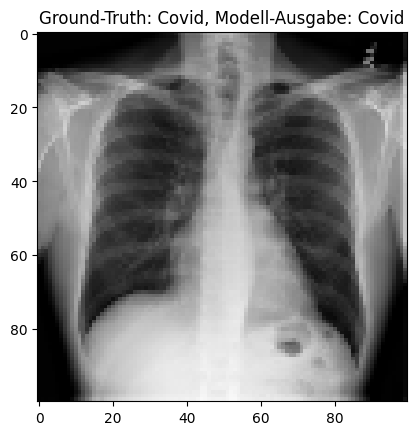

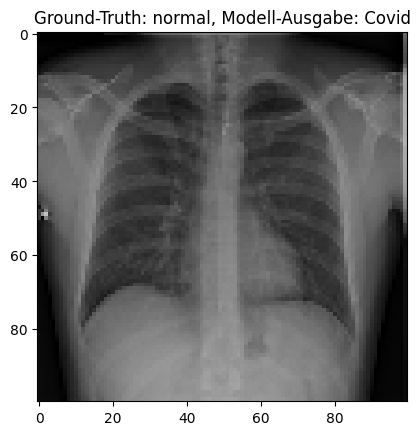

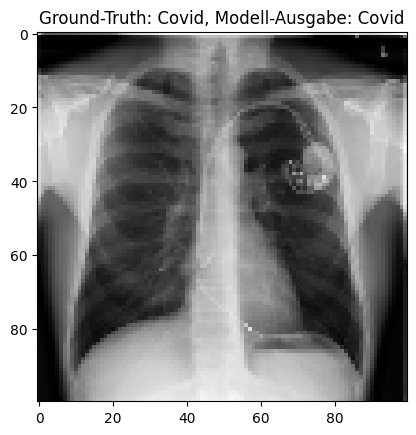

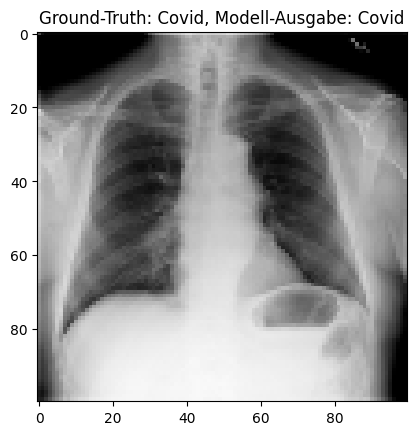

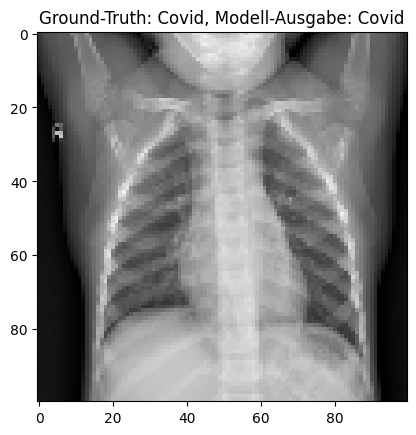

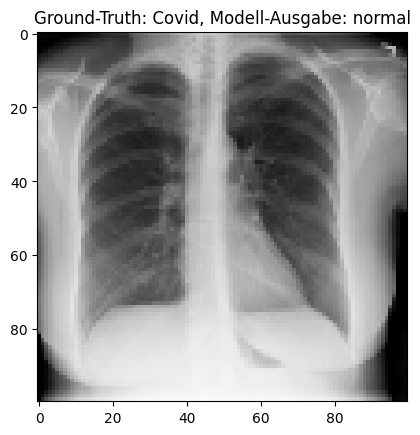

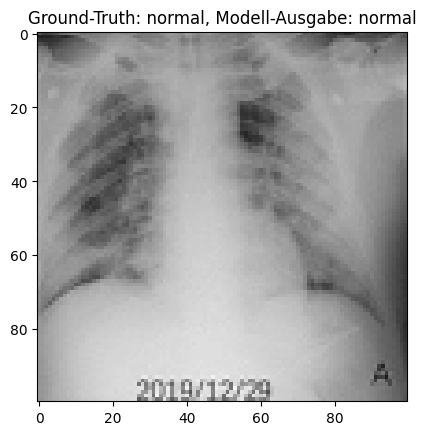

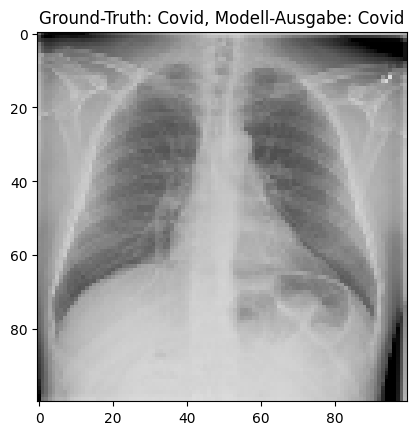

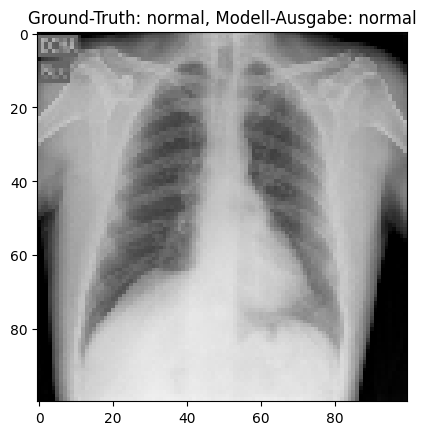

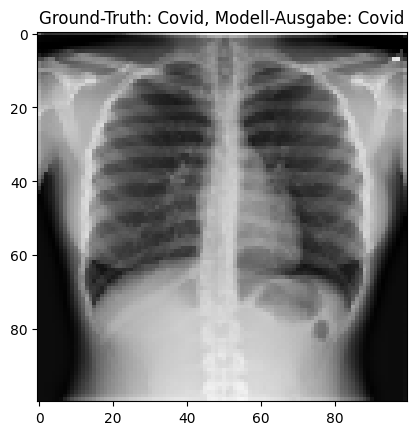

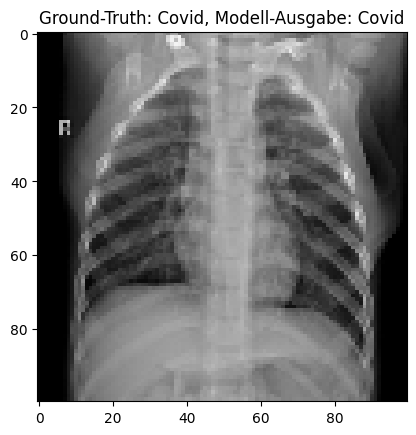

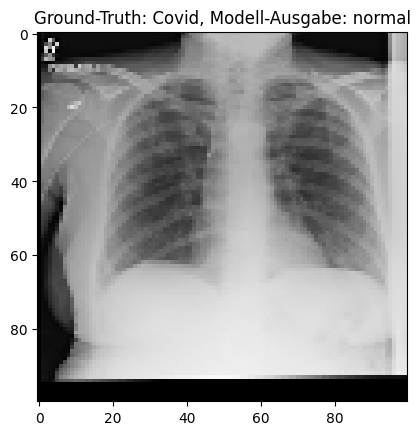

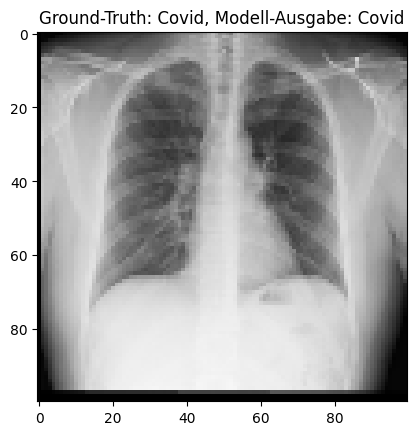

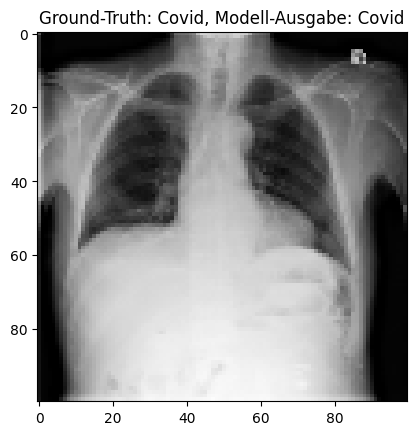

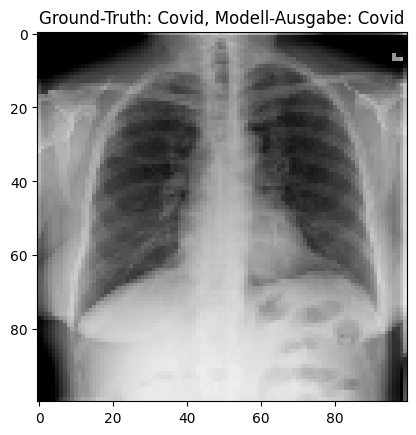

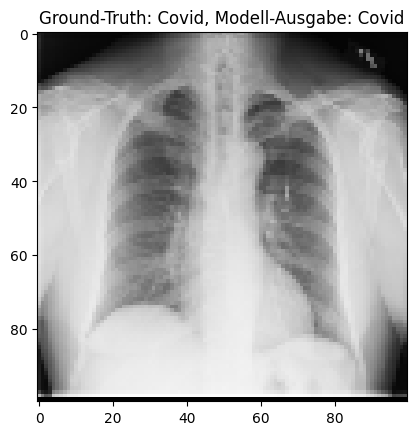

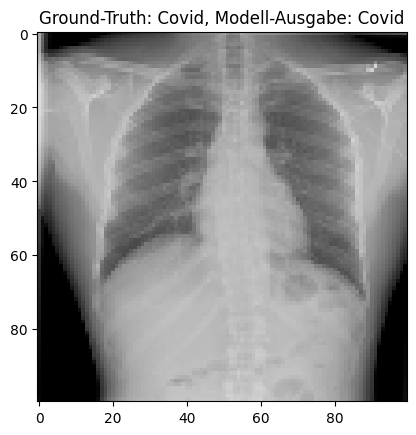

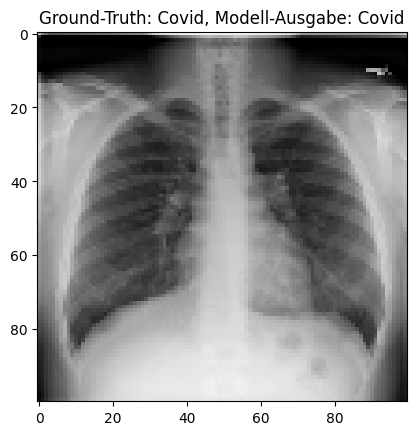

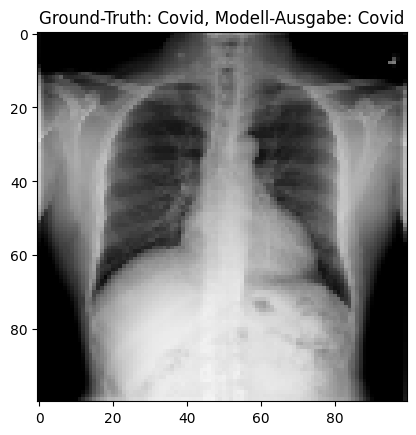

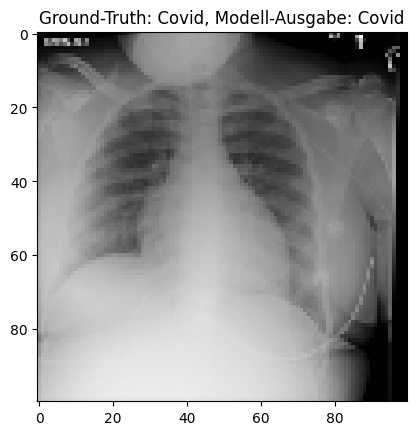

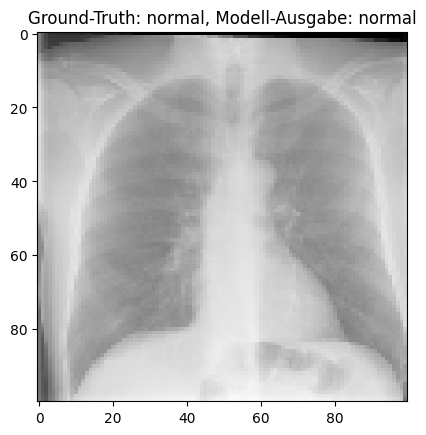

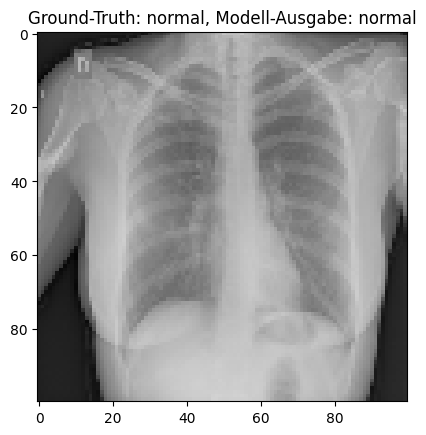

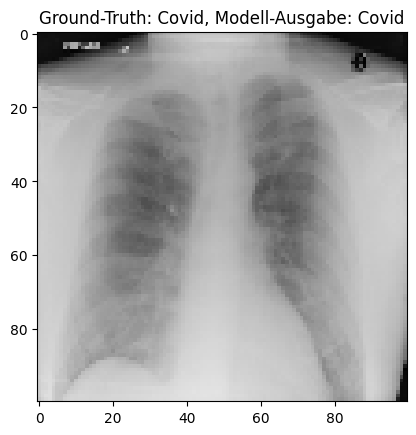

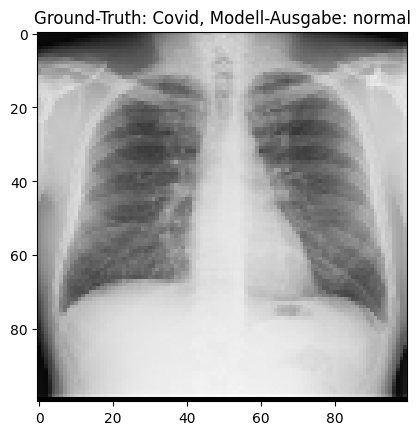

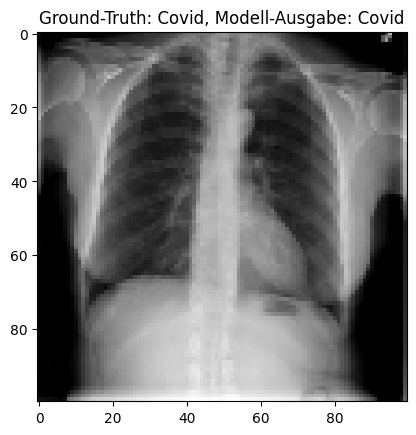

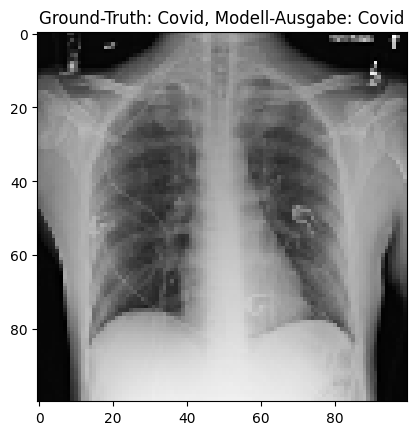

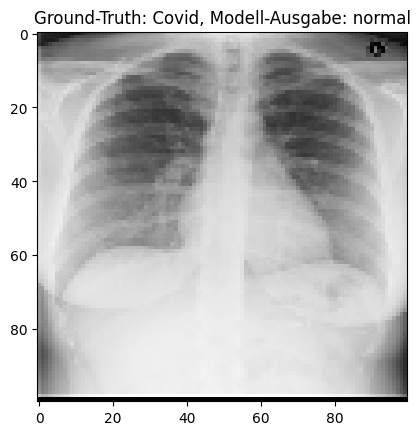

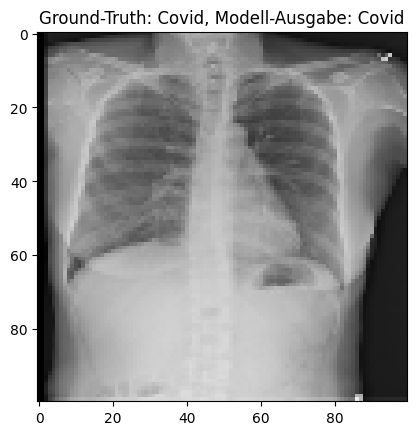

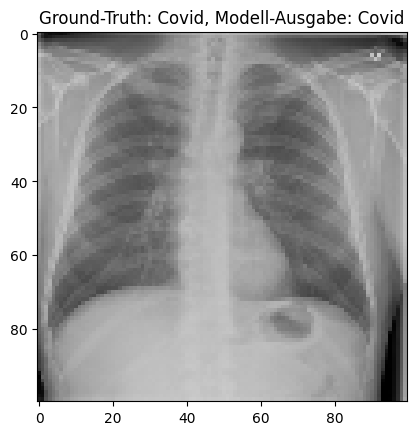

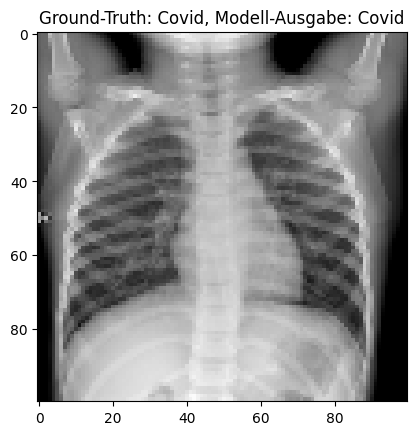

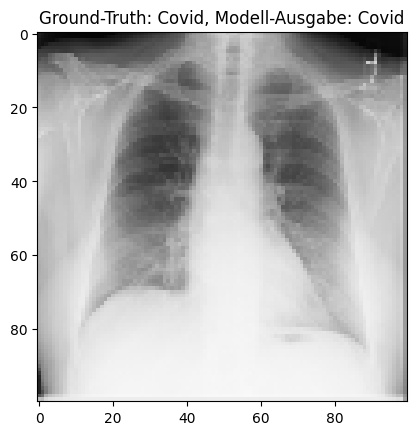

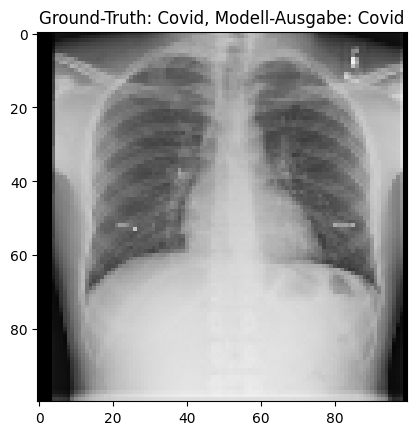

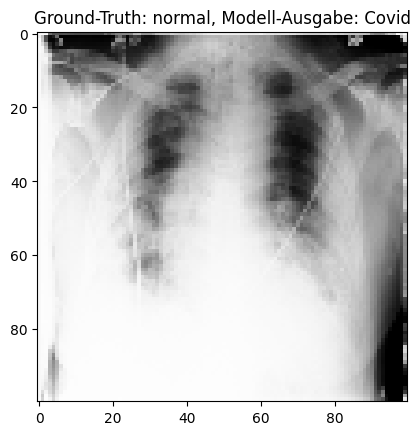

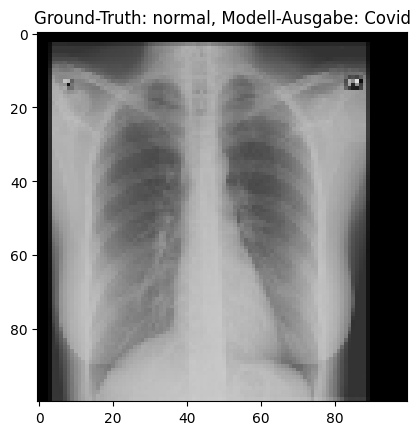

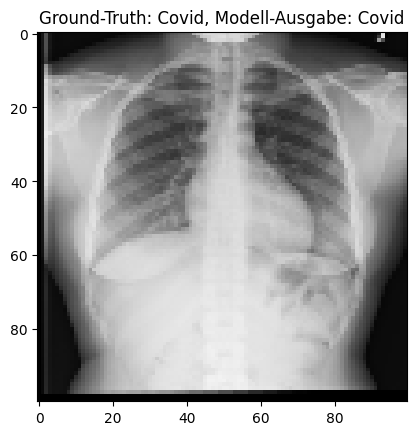

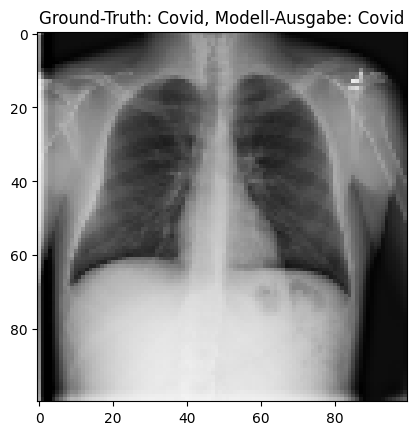

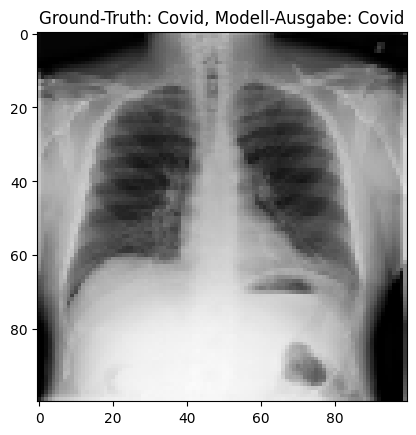

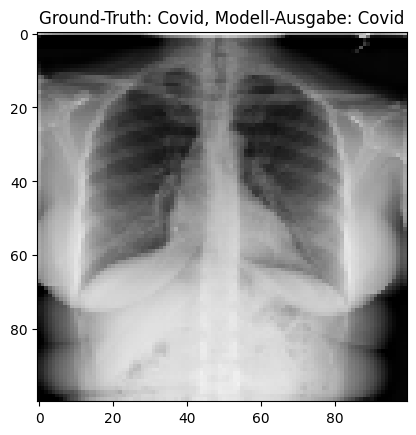

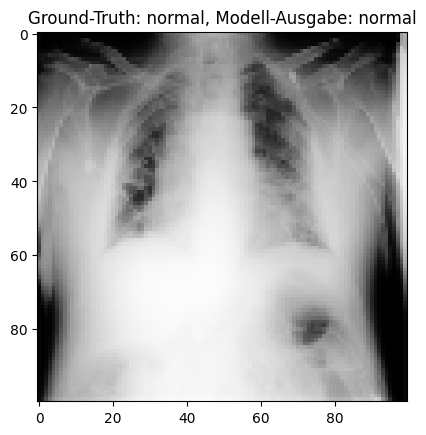

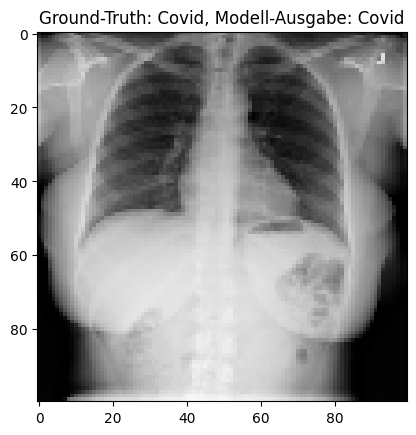

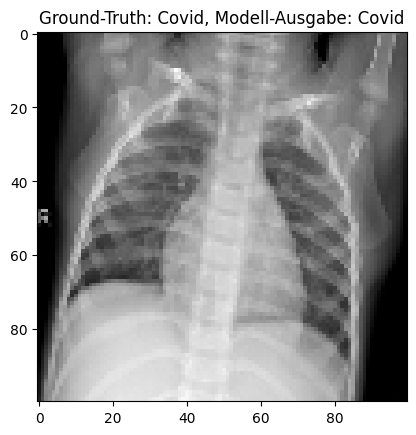

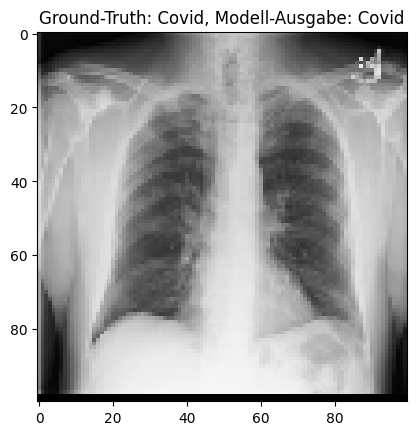

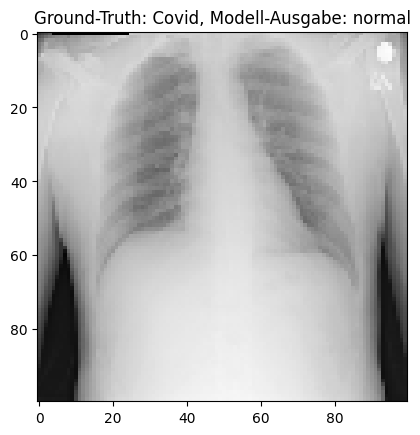

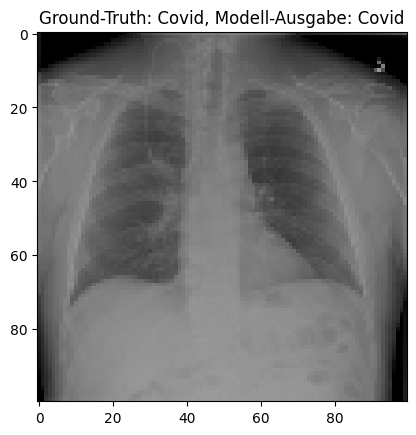

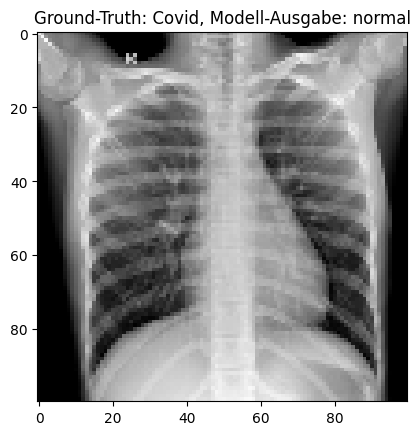

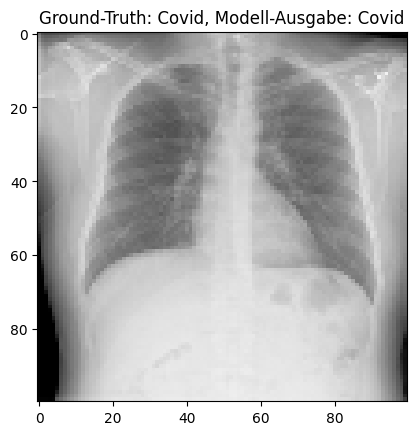

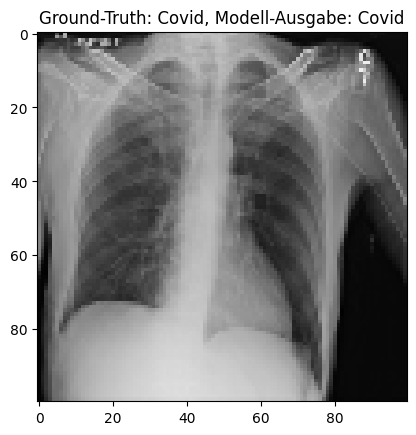

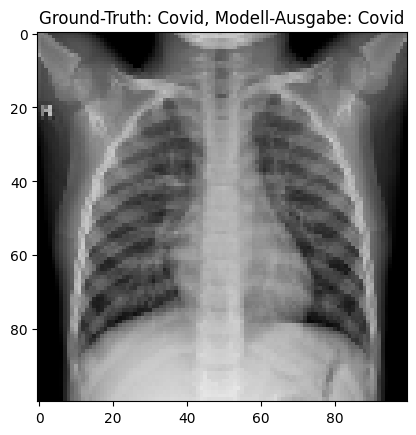

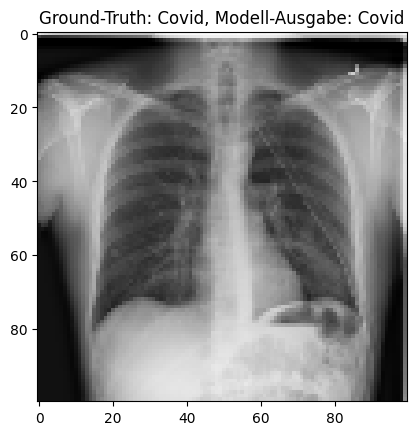

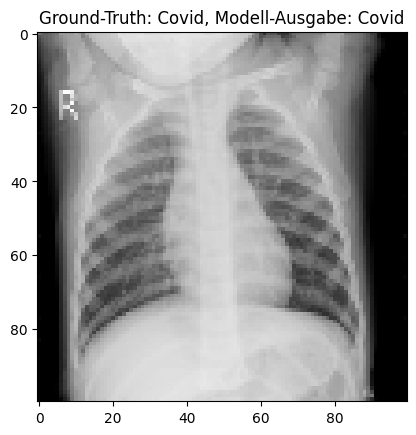

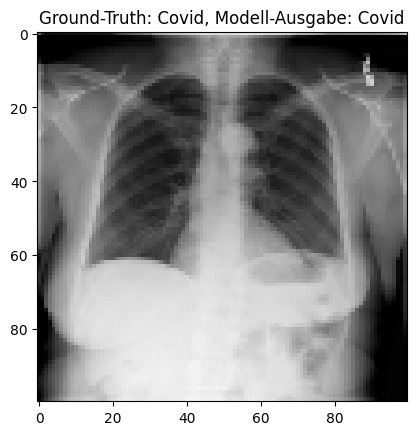

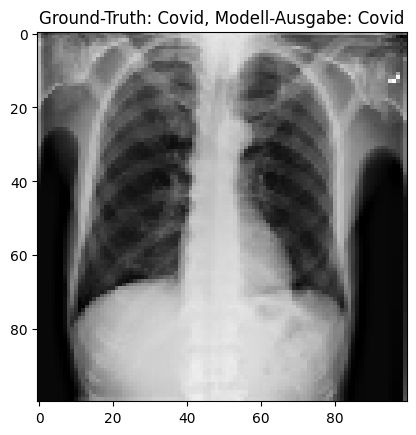

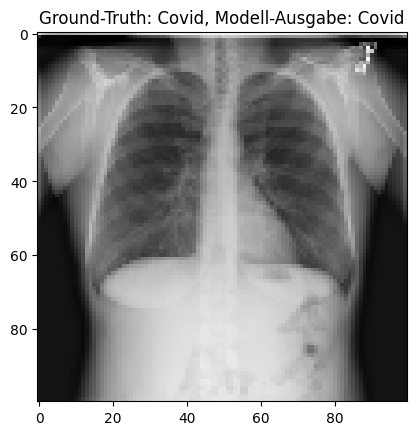

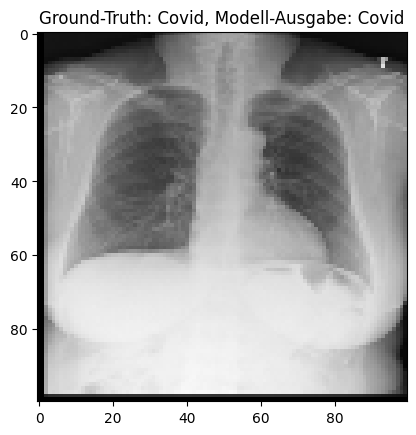

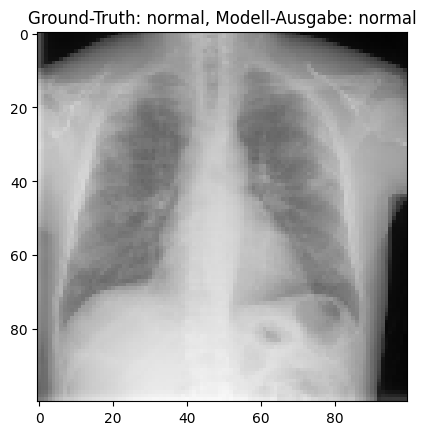

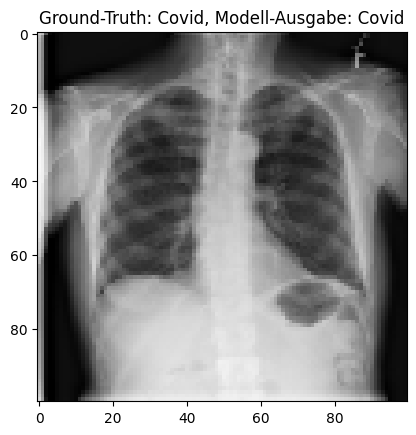

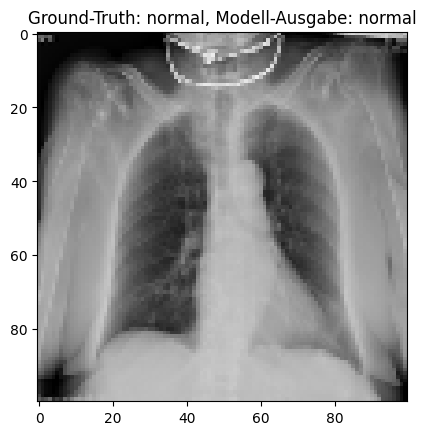

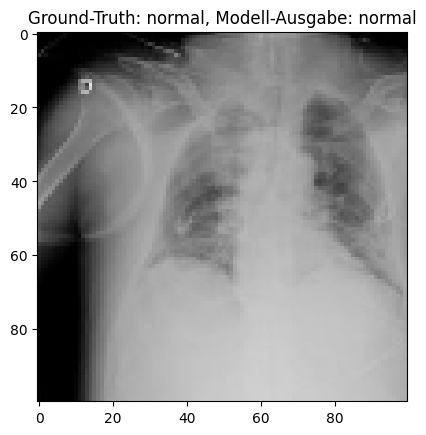

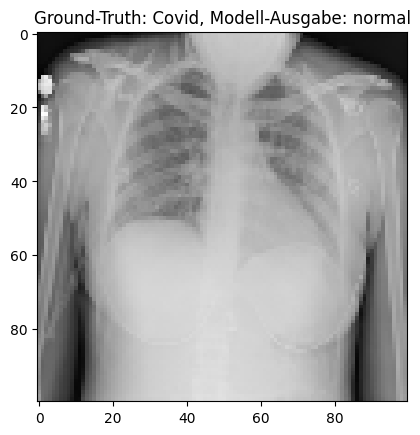

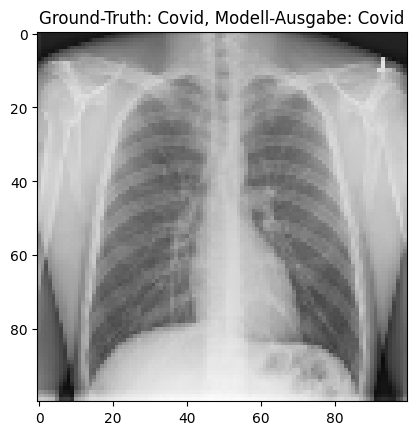

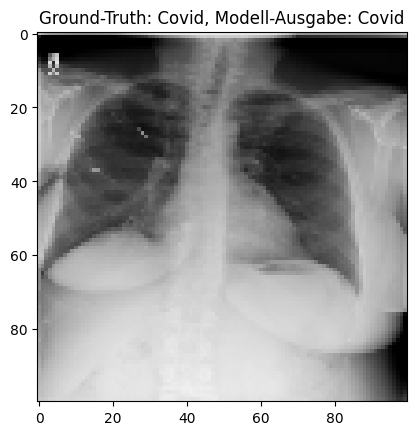

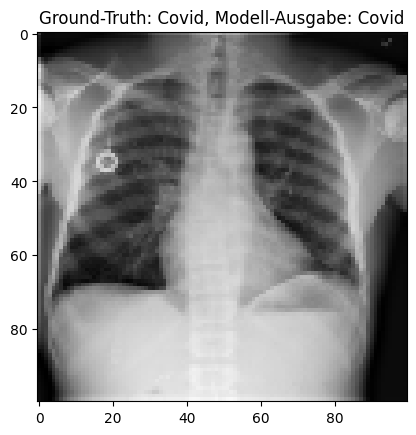

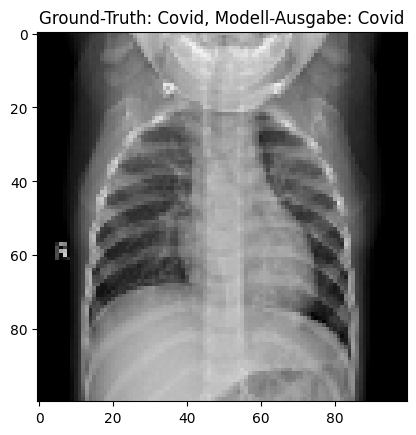

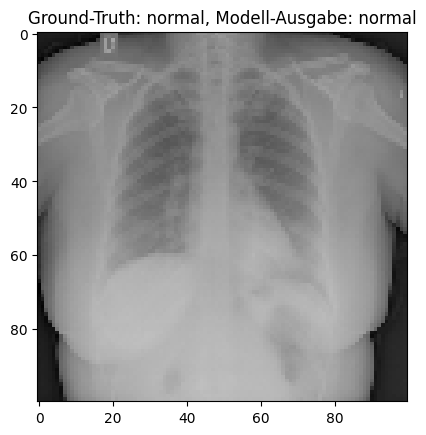

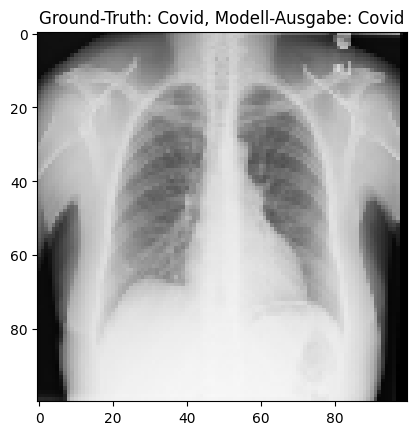

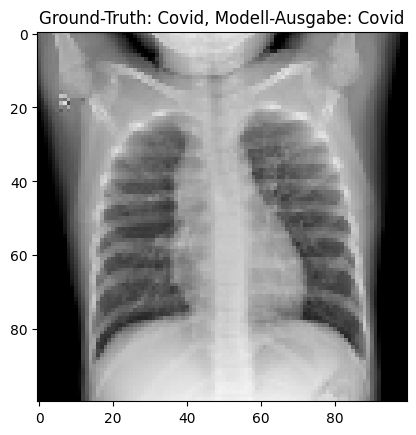

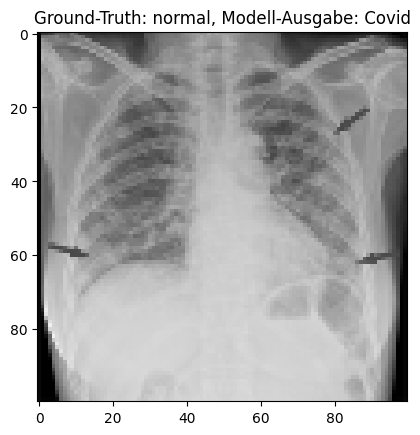

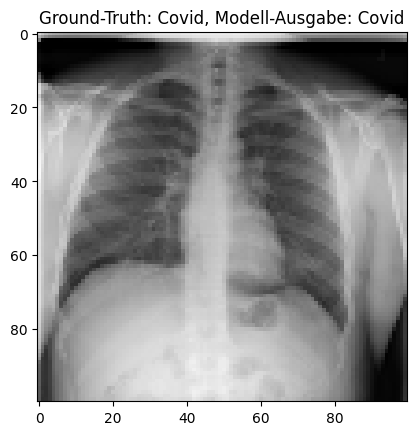

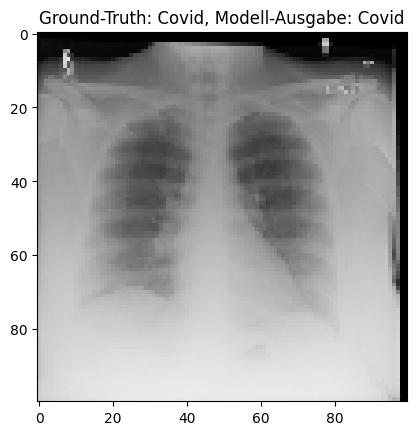

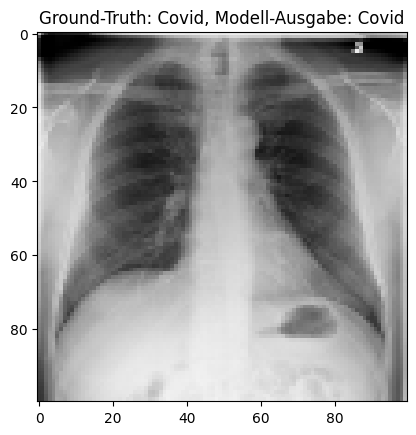

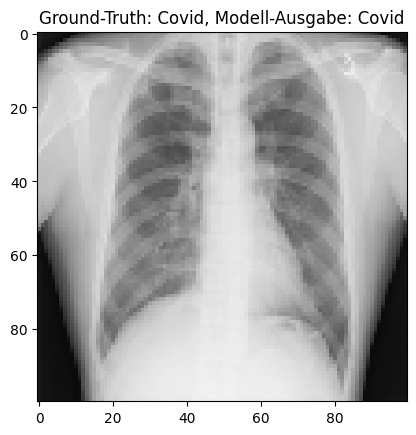

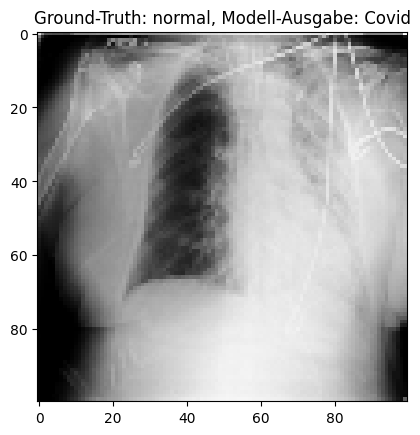

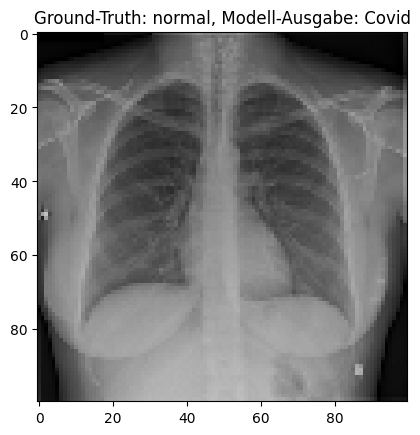

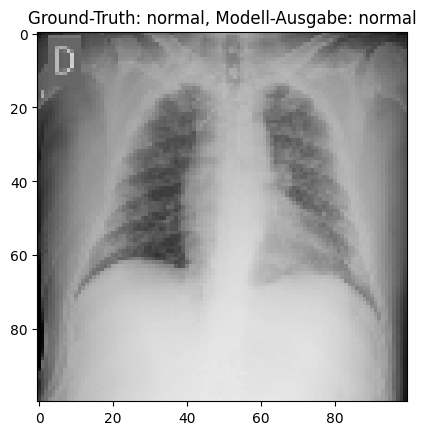

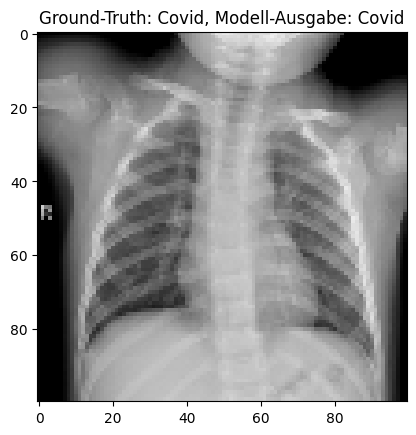

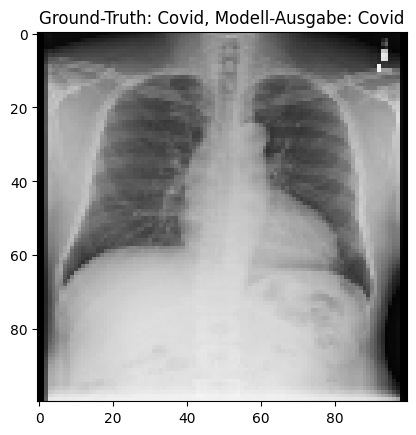

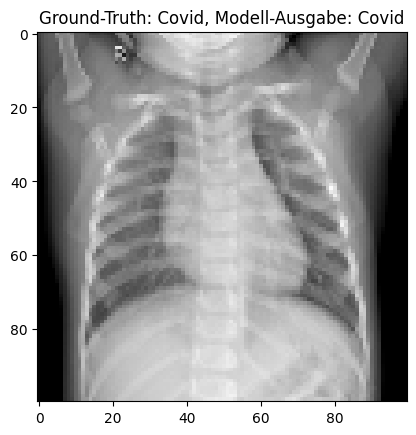

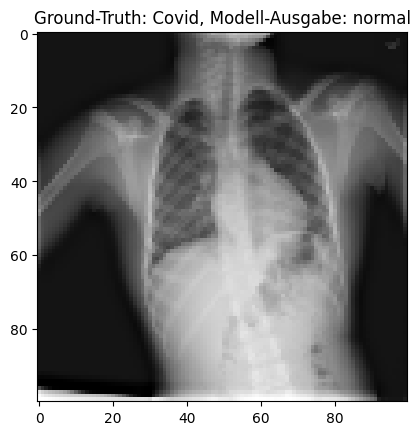

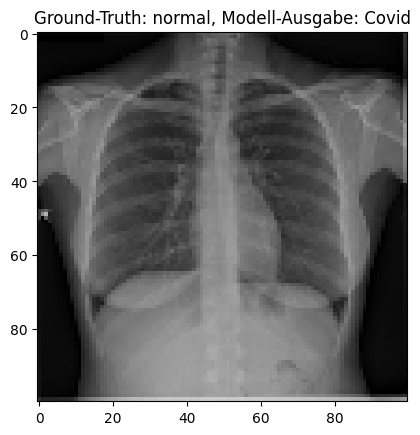

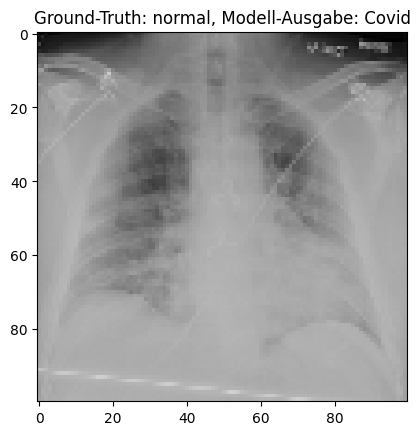

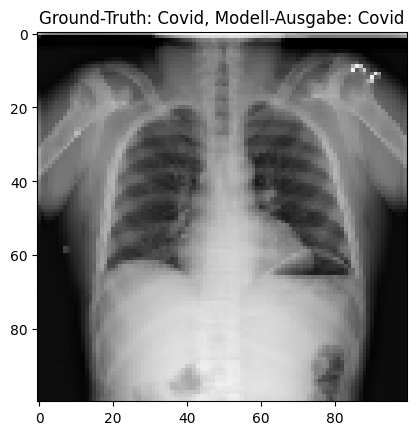

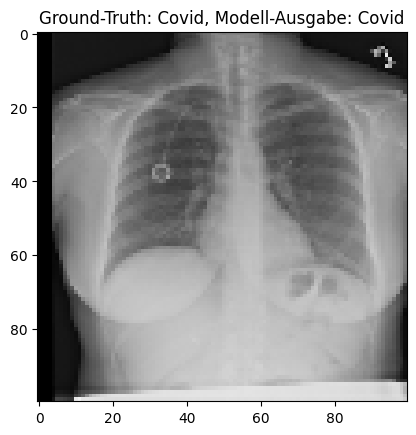

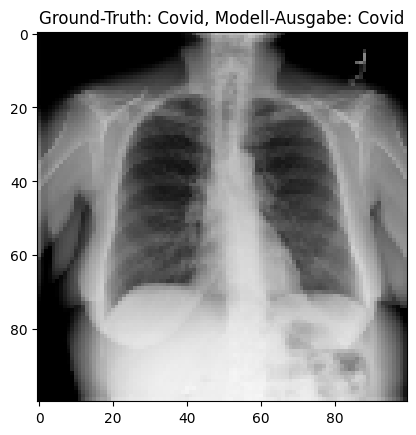

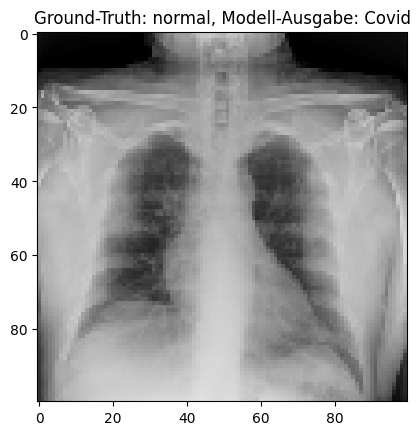

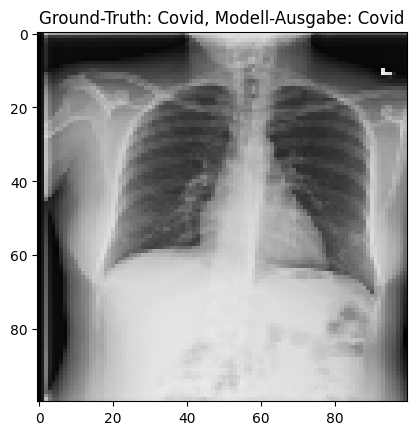

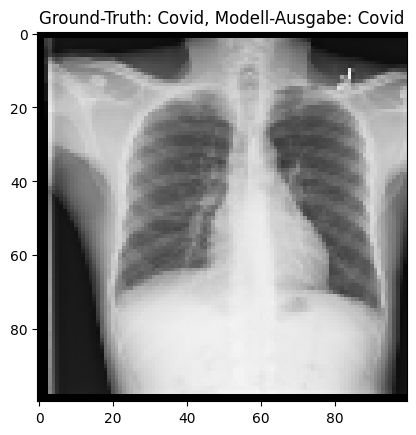

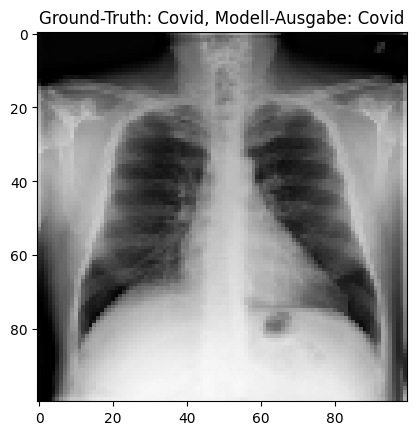

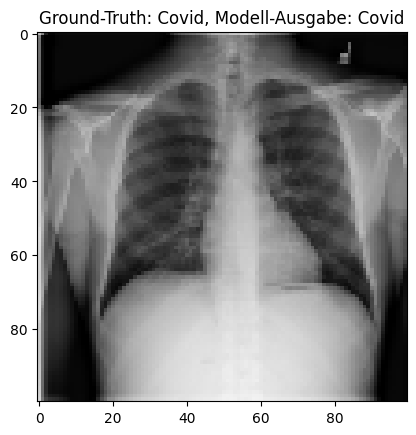

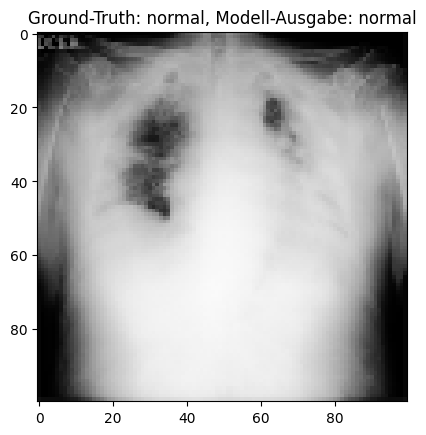

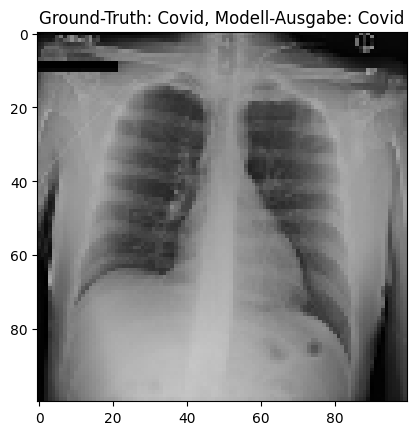

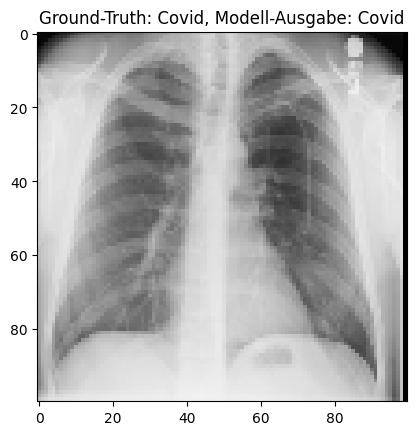

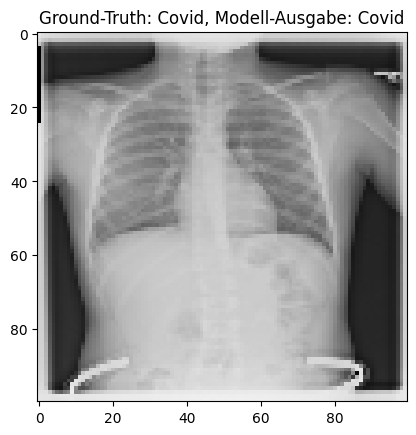

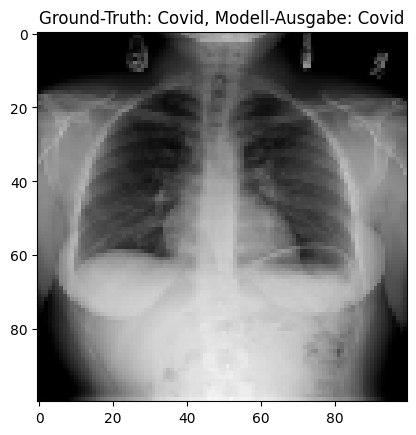

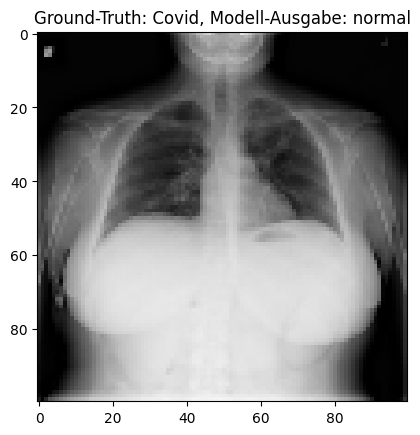

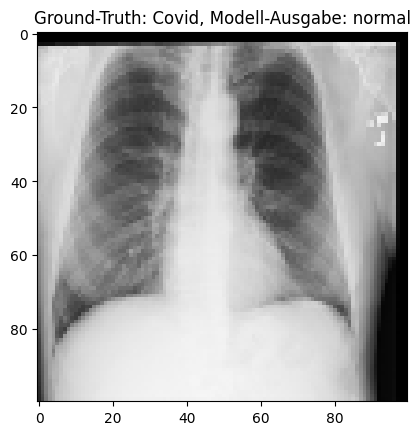

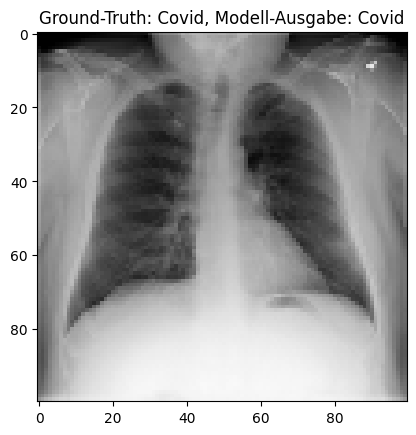

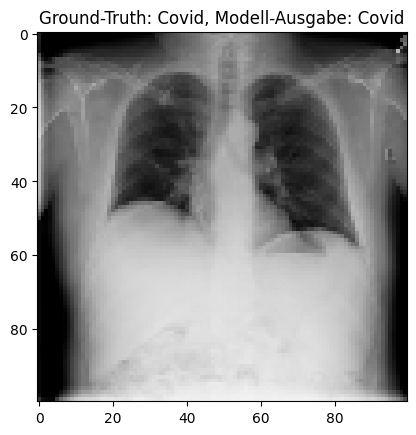

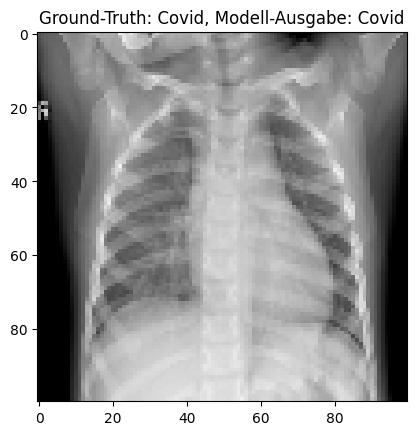

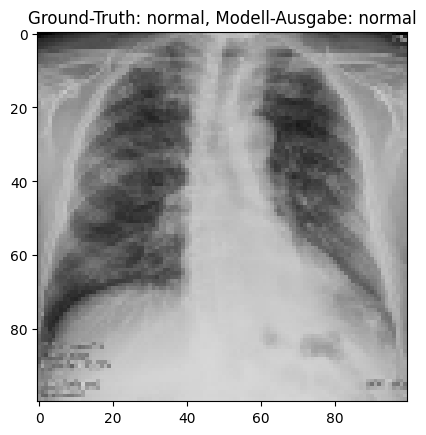

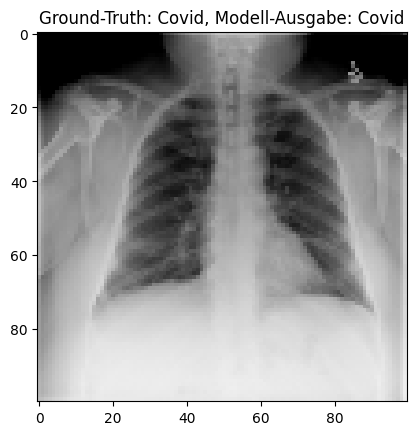

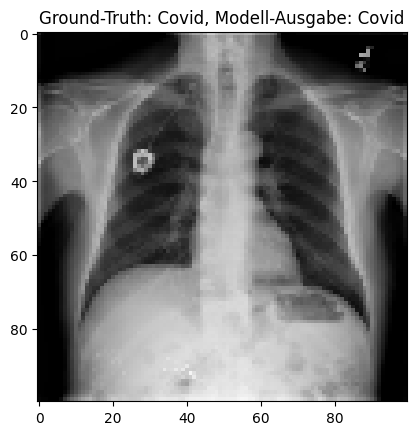

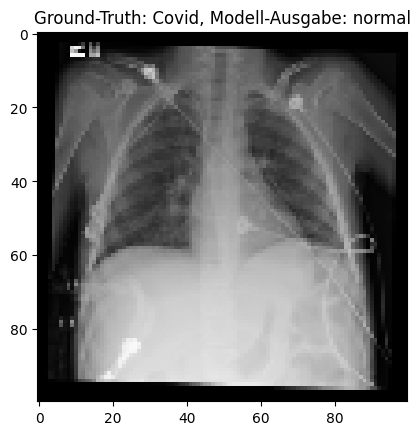

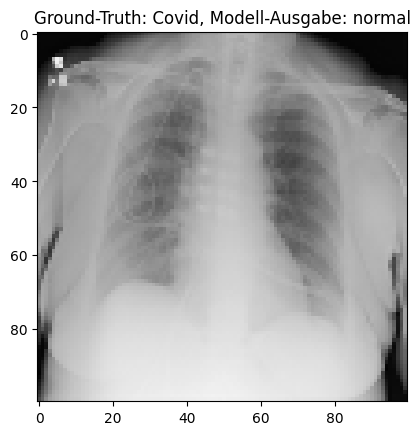

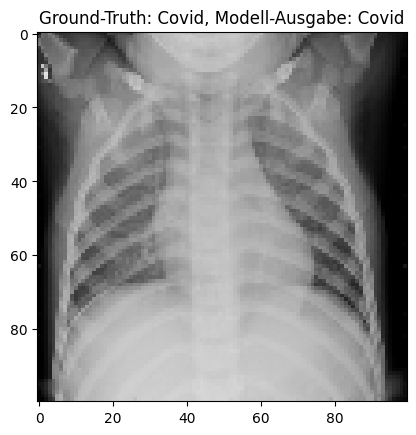

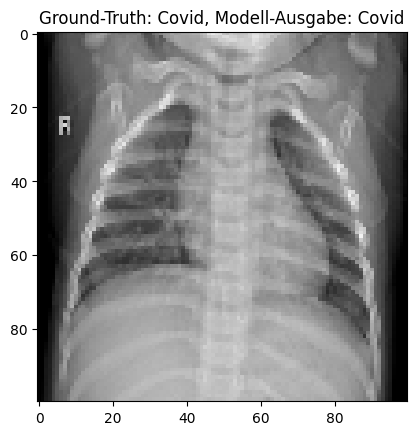

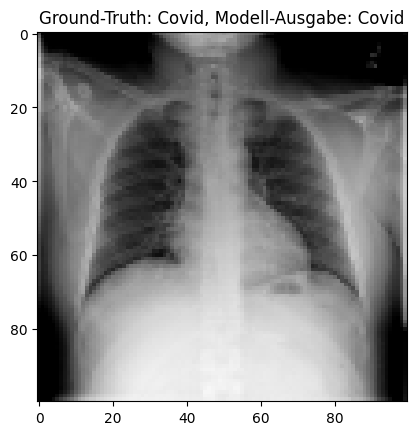

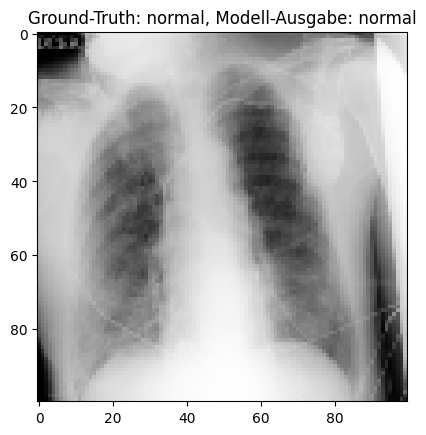

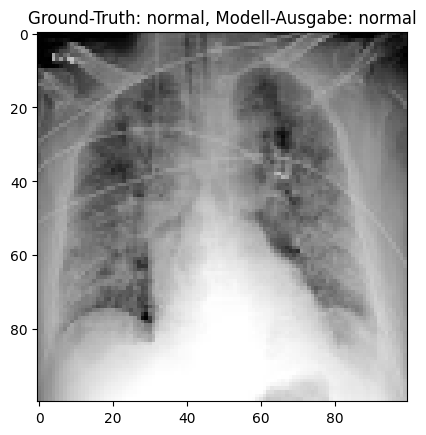

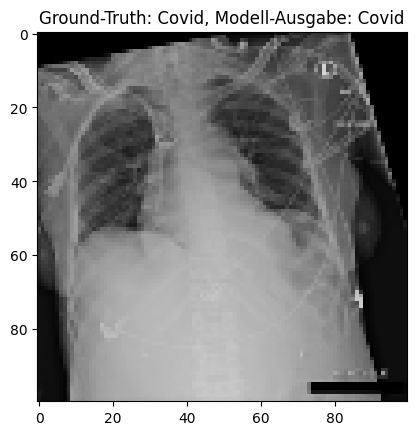

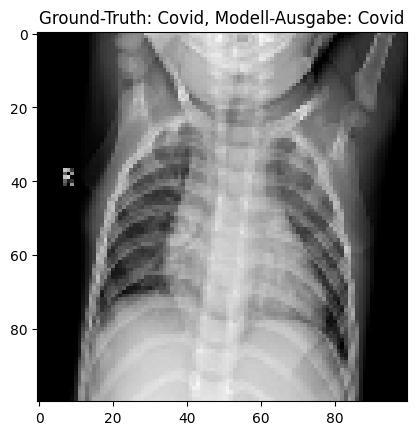

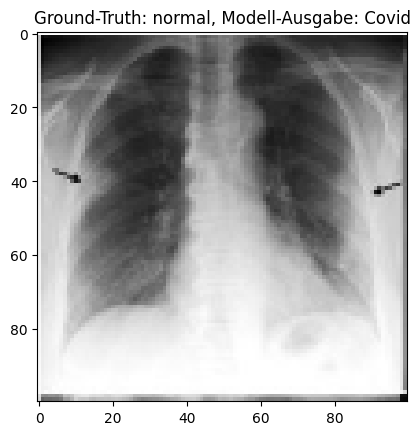

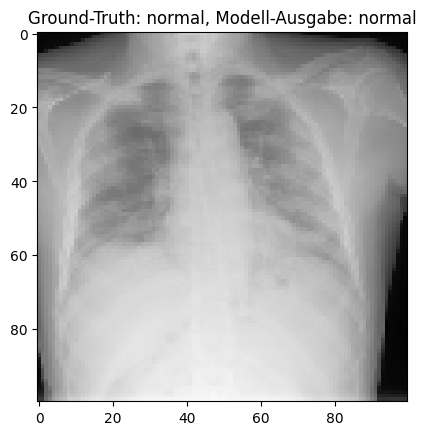

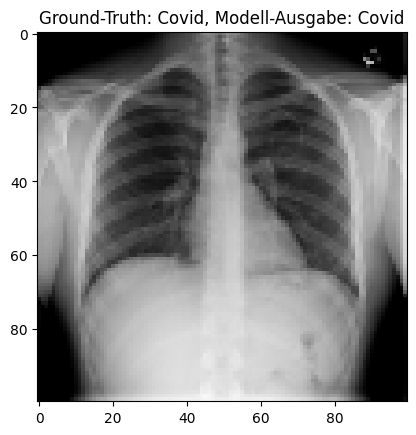

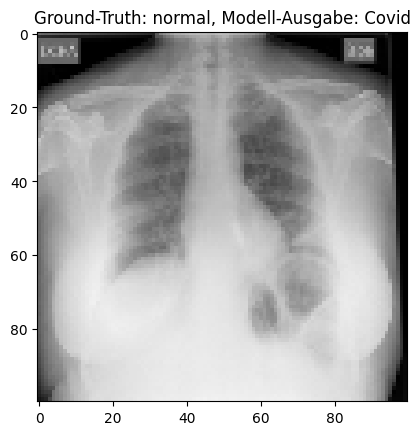

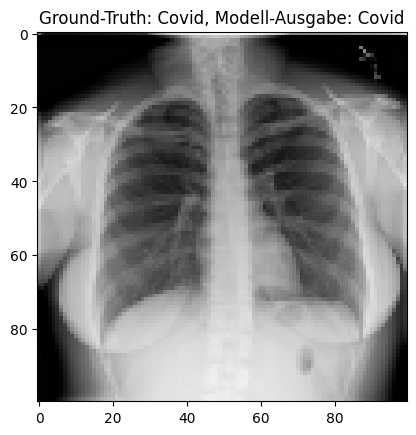

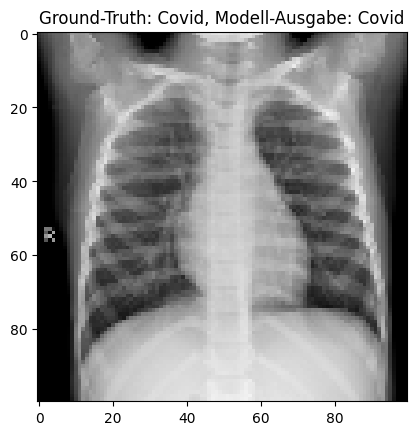

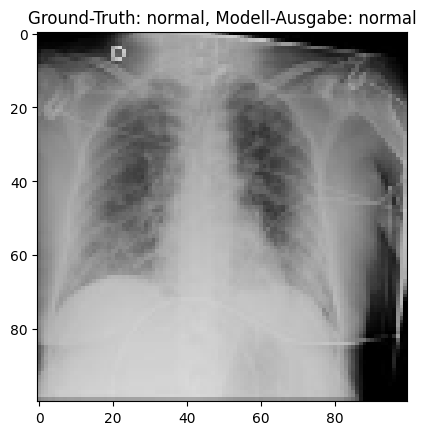

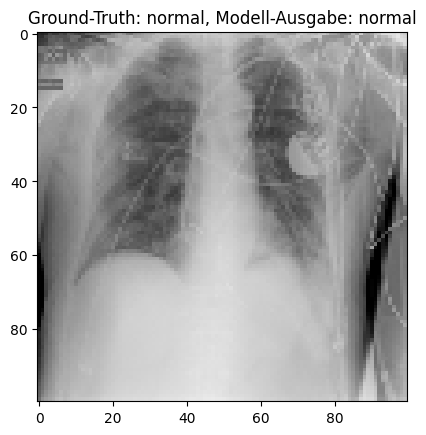

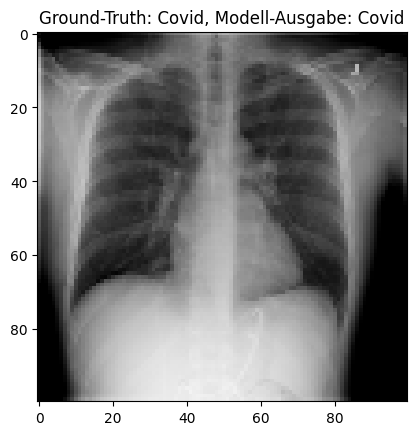

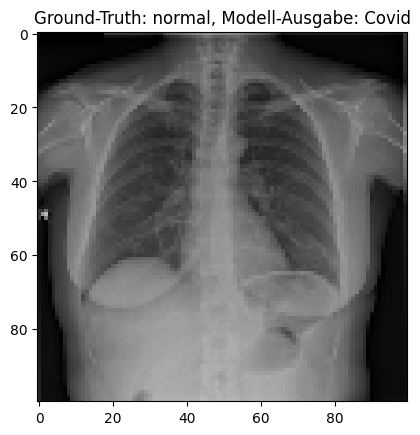

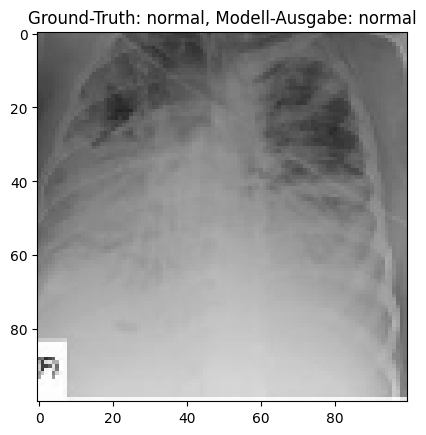

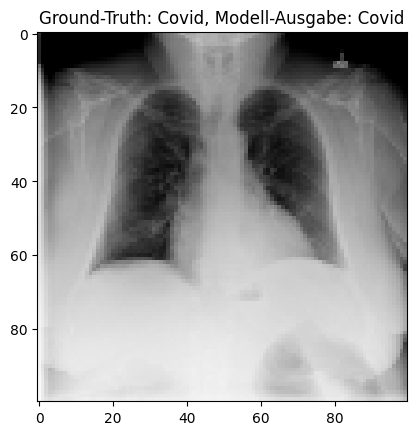

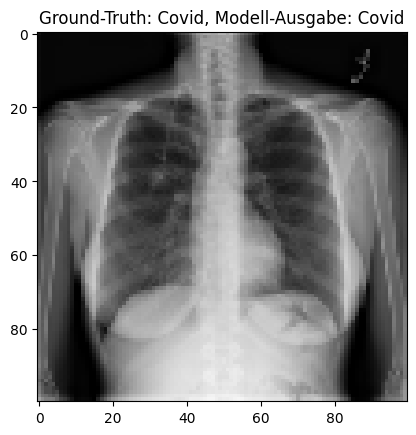

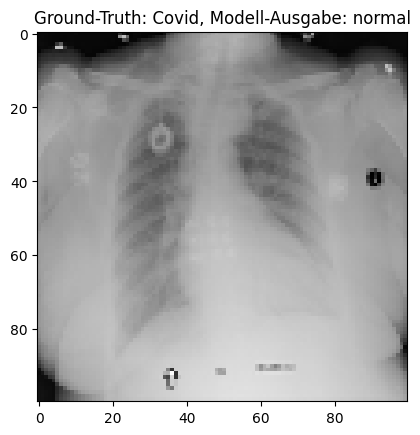

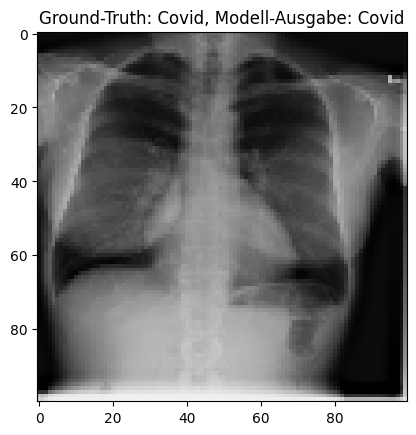

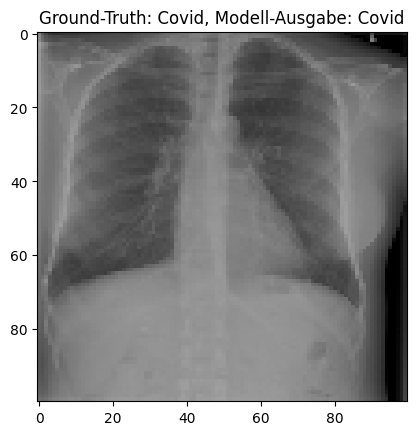

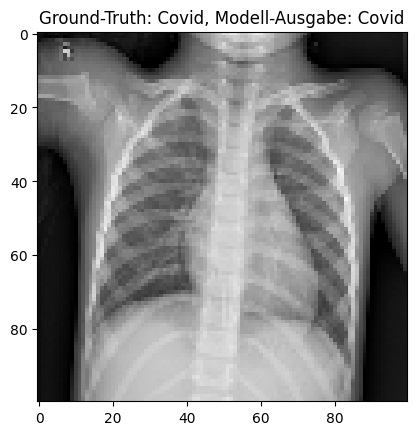

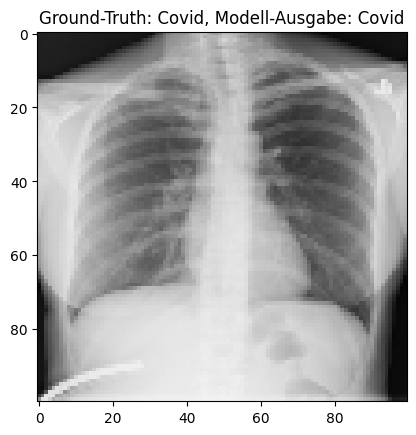

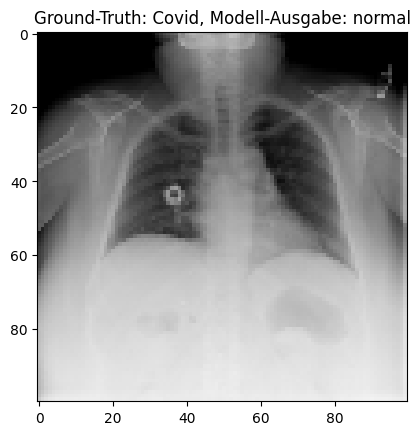

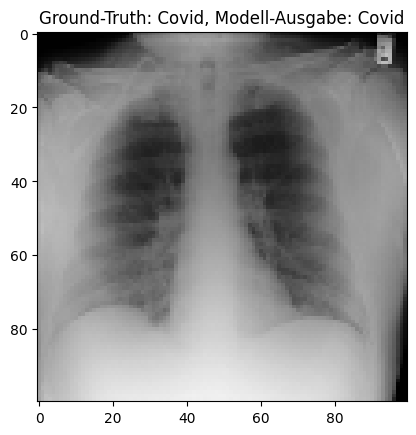

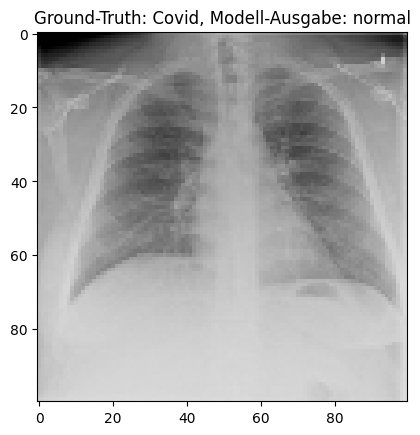

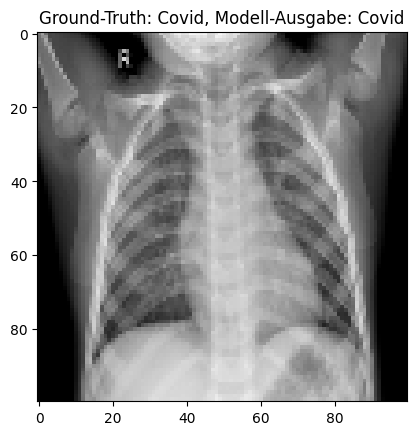

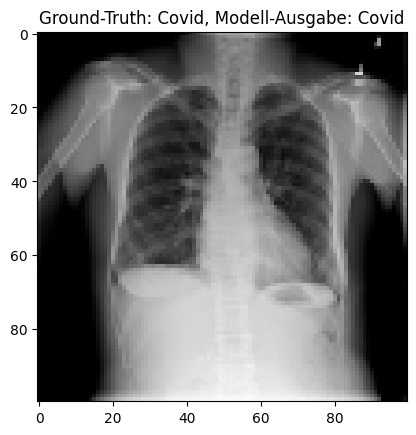

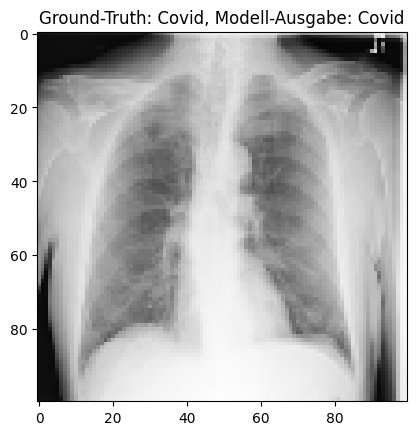

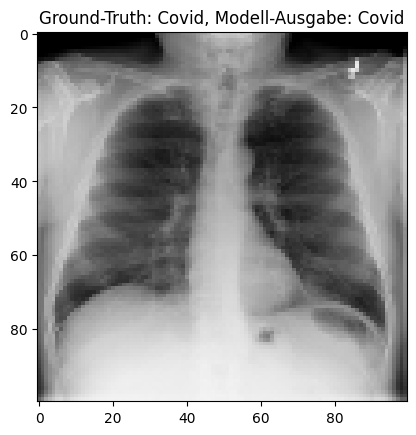

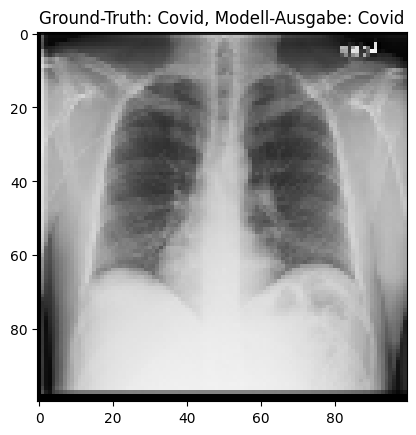

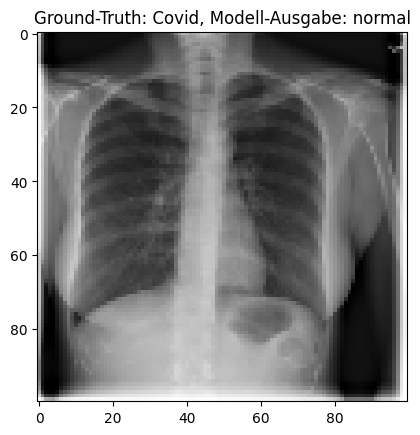

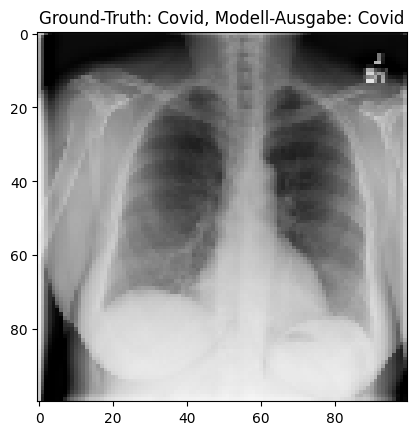

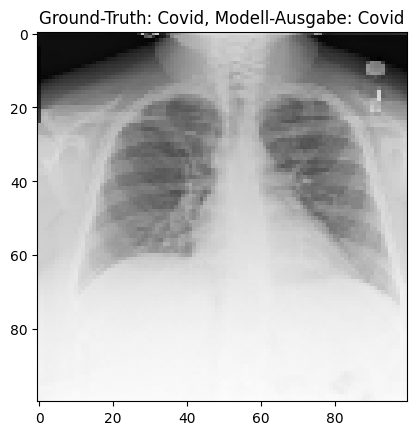

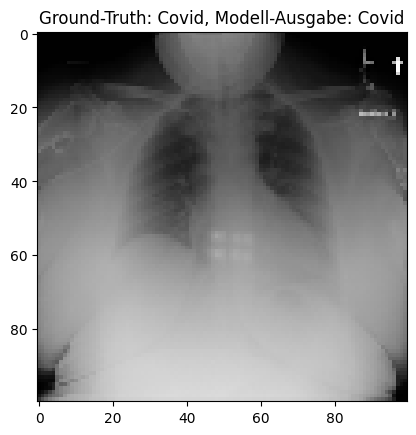

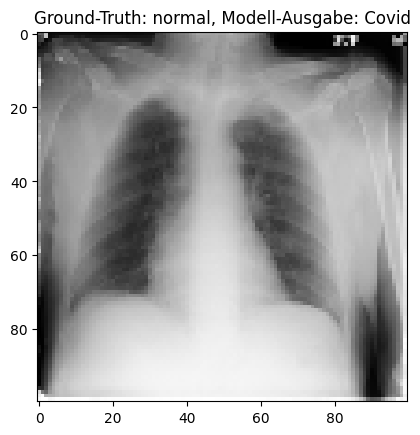

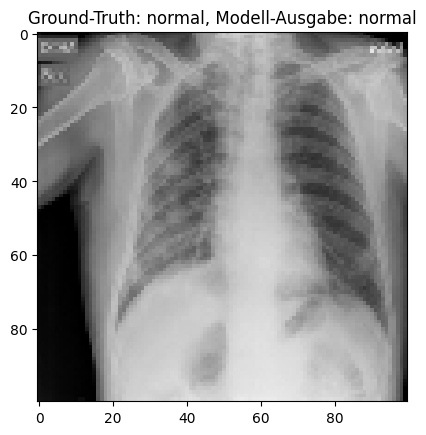

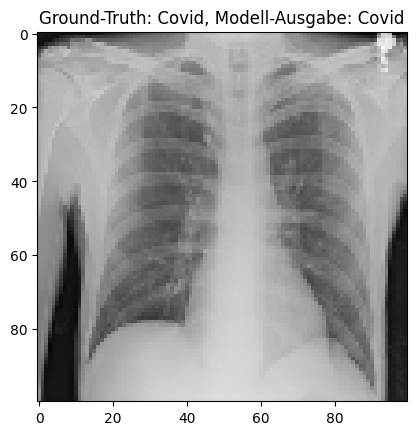

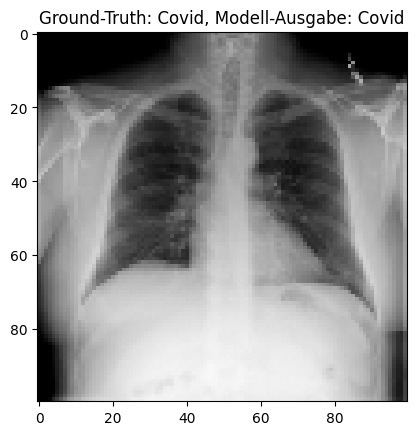

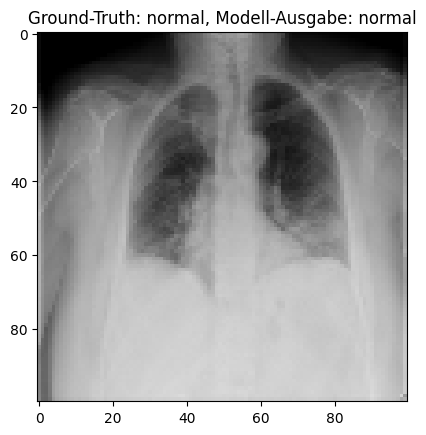

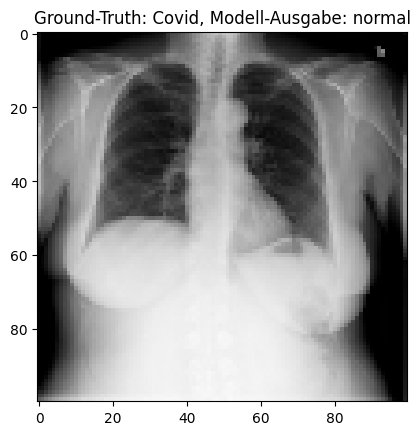

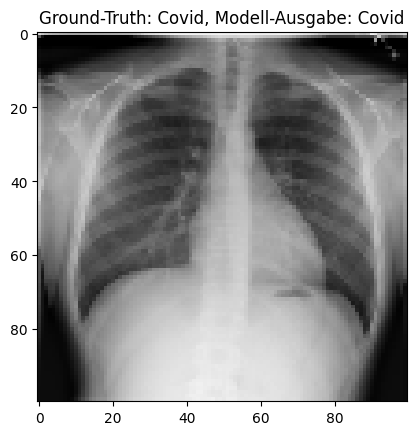

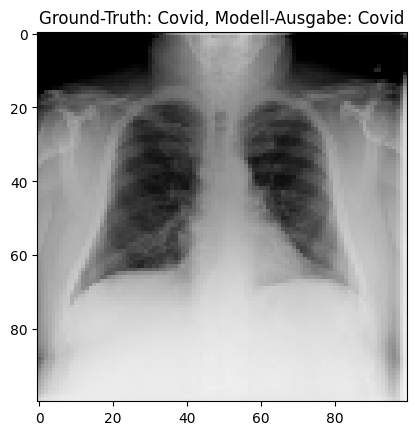

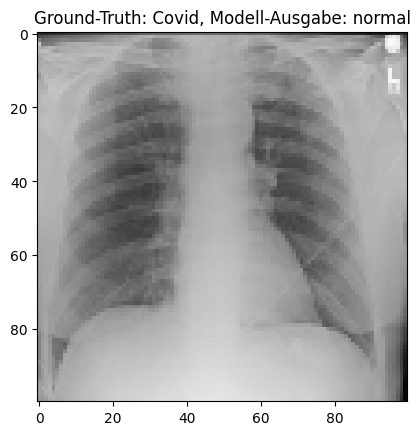

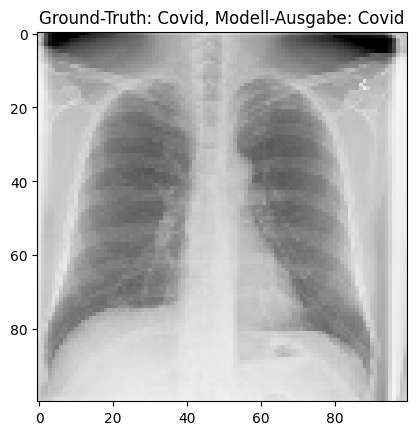

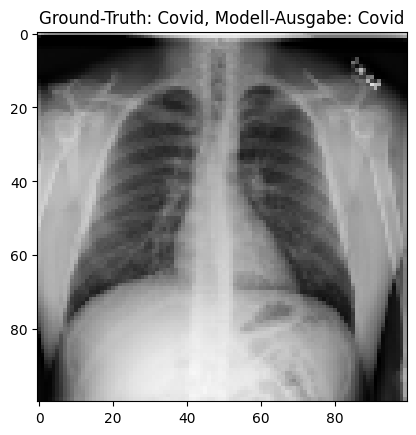

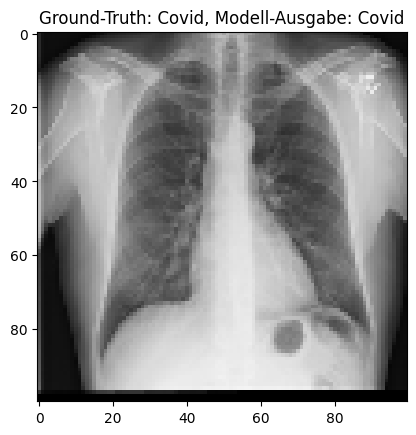

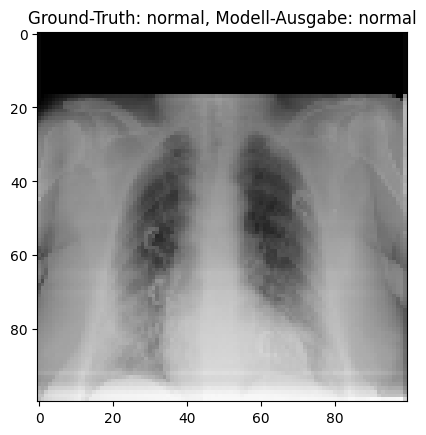

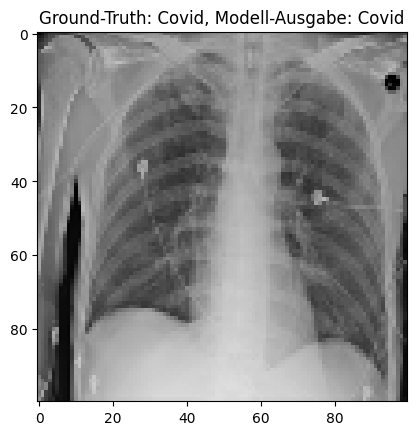

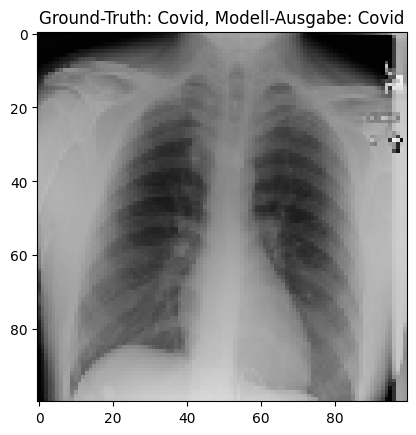

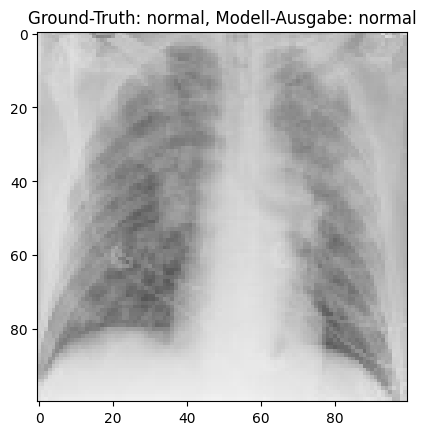

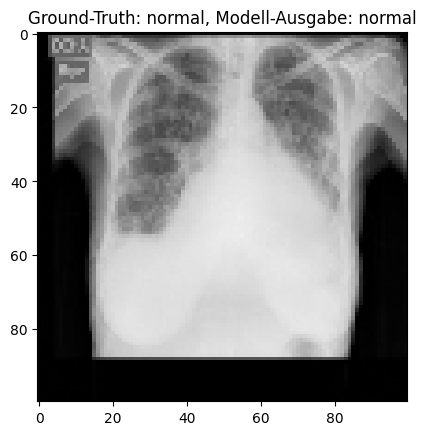

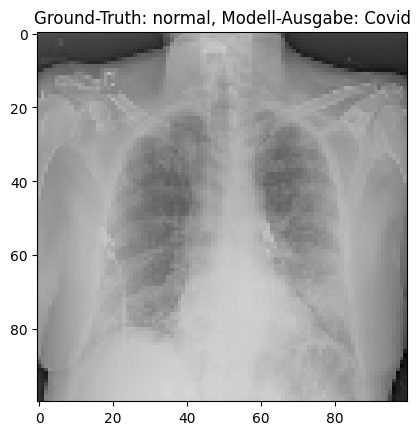

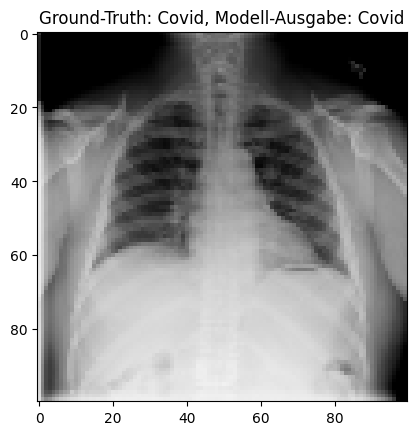

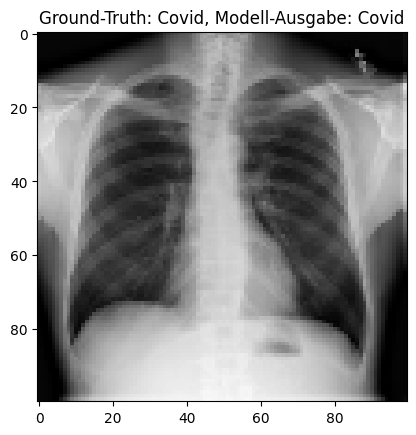

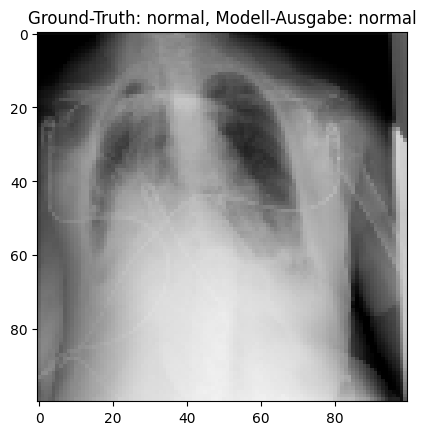

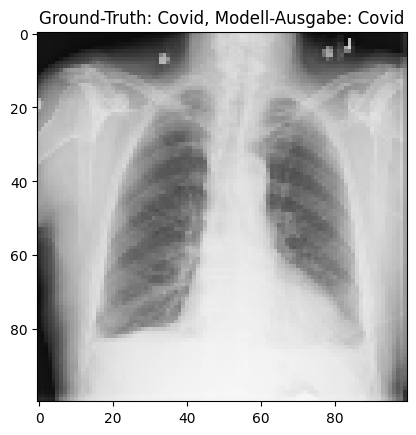

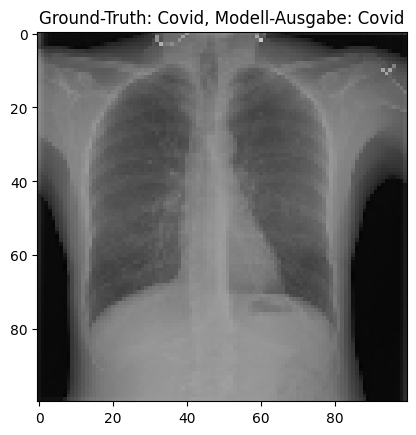

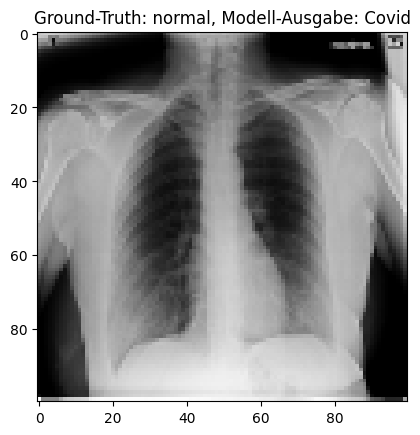

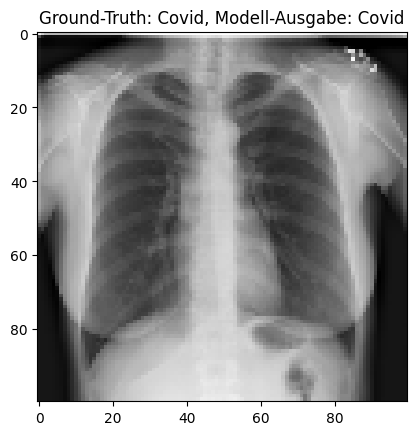

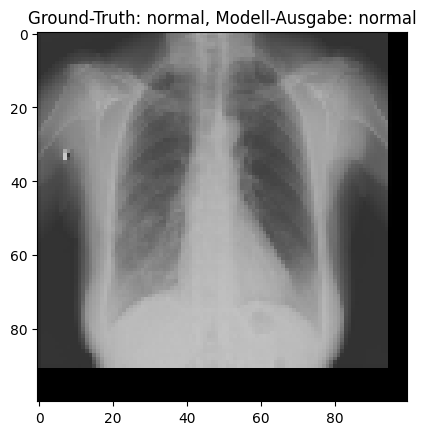

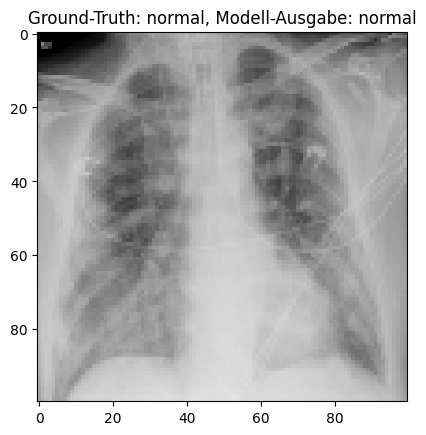

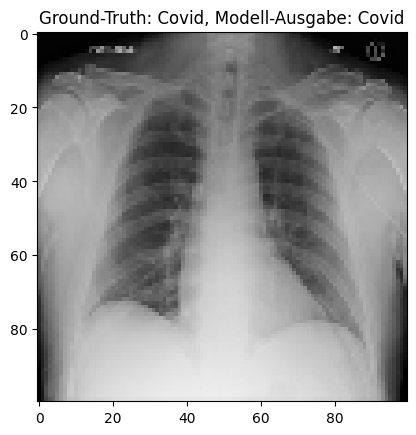

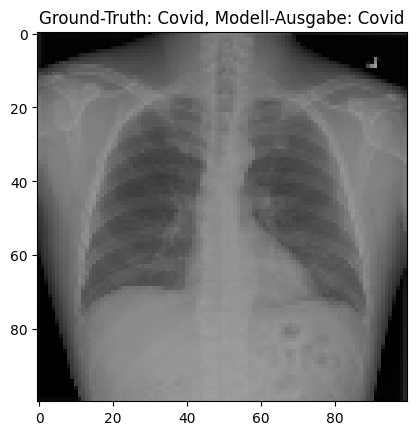

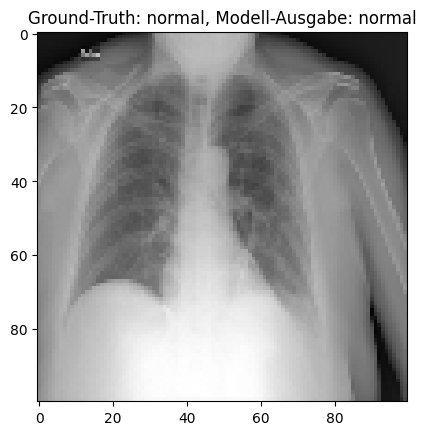

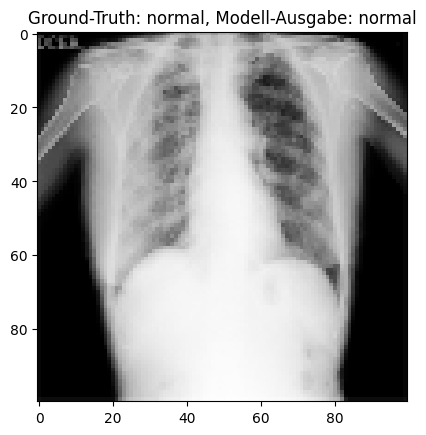

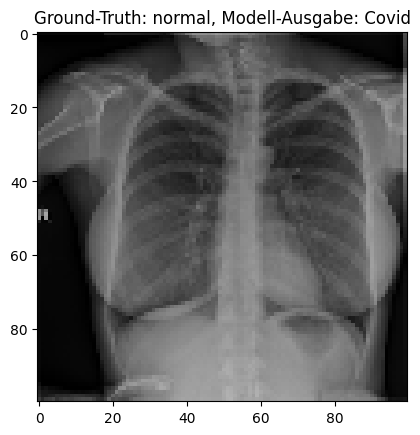

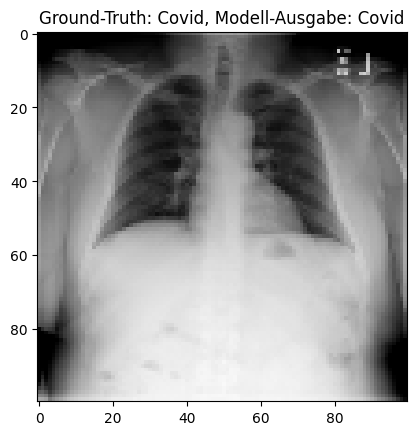

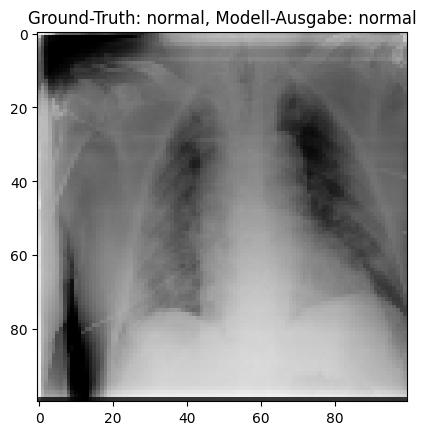

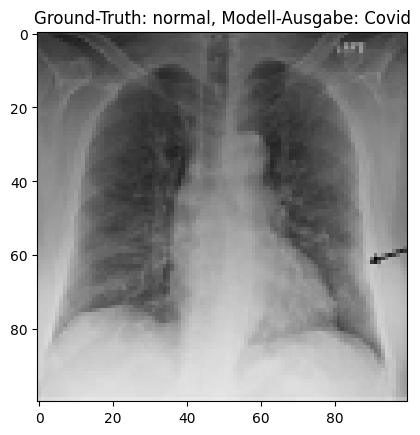

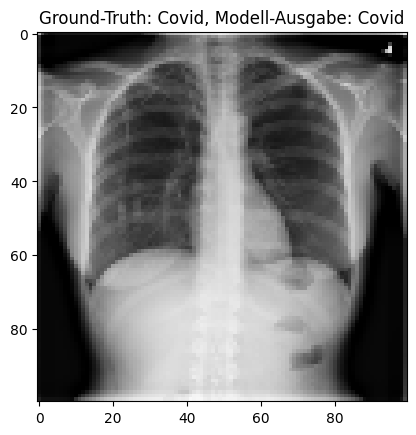

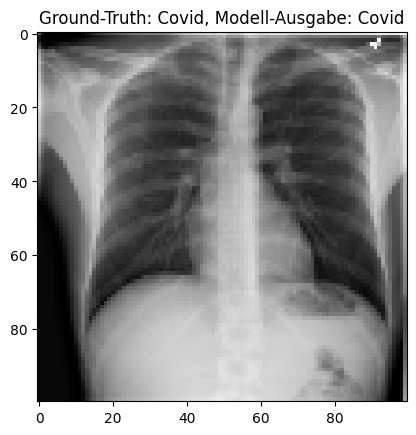

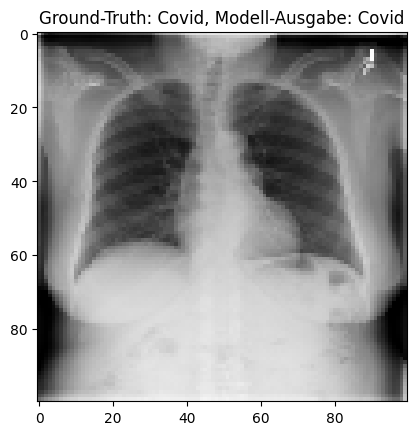

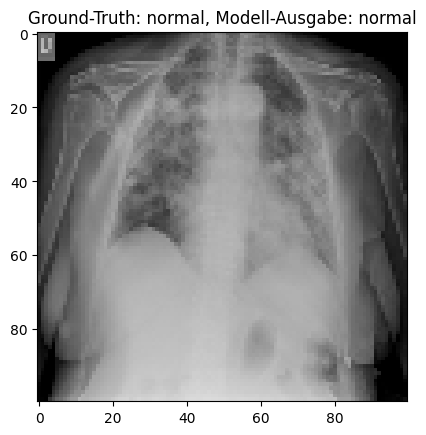

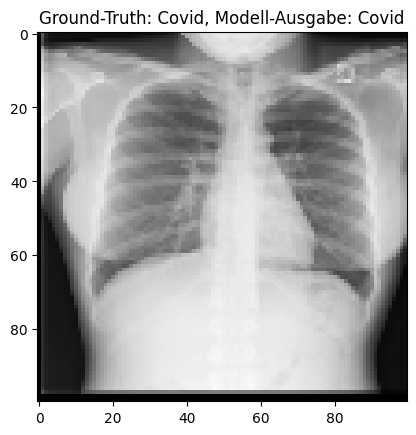

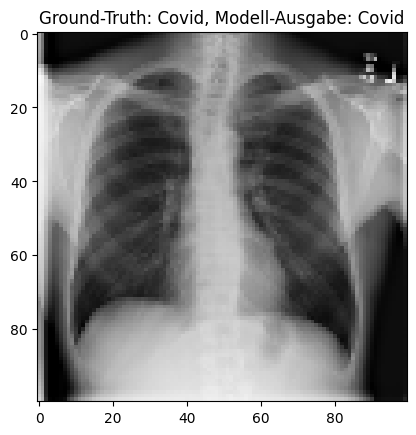

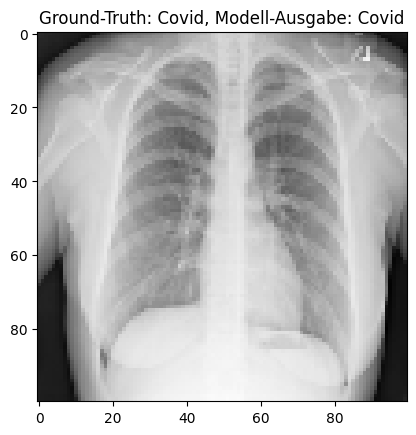

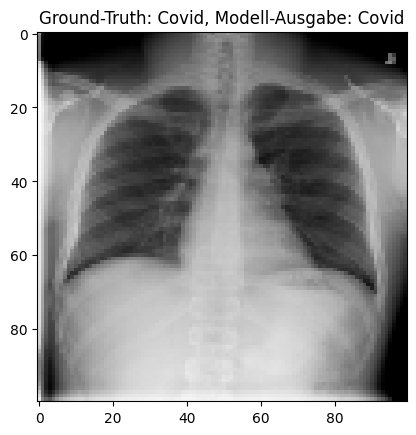

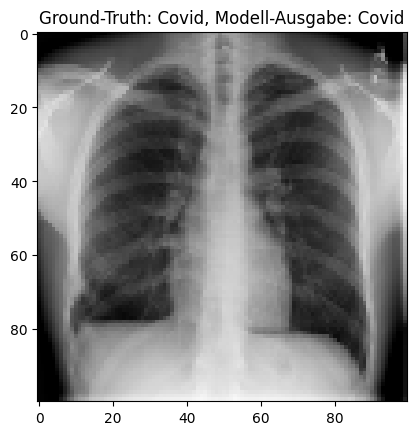

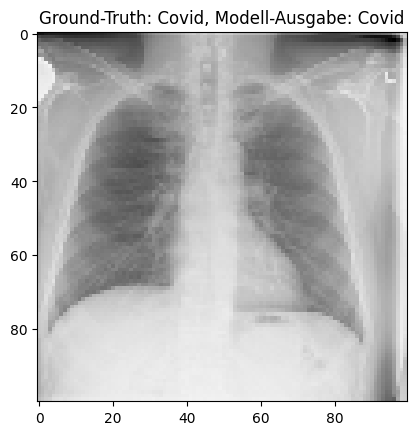

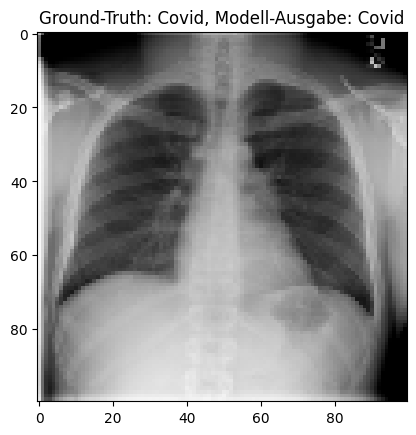

In [26]:
# Ausgabe von Beispielbildern inklusive vorhergesagtem Label

def prediction_to_class(prediction: int):
  return "Covid" if prediction == 0 else "normal"


for i in range(len(x_test)):
  plt.figure()
  plt.imshow(x_test[i])
  plt.title(f"Ground-Truth: {prediction_to_class(y_test[i])}, Prediction: {prediction_to_class(y_pred_bin[i])}")
  plt.show()